In [1]:
!nvidia-smi

Thu Nov 30 21:41:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install pandas

In [3]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F
from scipy.io import arff


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [4]:
!gdown --id 16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT
To: /content/ECG5000.zip
100% 10.6M/10.6M [00:00<00:00, 38.2MB/s]


In [5]:
!unzip -qq ECG5000.zip

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
with open('ECG5000_TRAIN.arff') as f:
  maldata=arff.loadarff(f)
  train = pd.DataFrame(maldata[0])

with open('ECG5000_TEST.arff') as f:
  maldata=arff.loadarff(f)
  test = pd.DataFrame(maldata[0])

In [8]:
df = train.append(test)
df = df.sample(frac=1.0)
df.shape

<ipython-input-8-0687e4e5ac46>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train.append(test)


(5000, 141)

In [9]:
df.head()

att1      att2      att3      att4      att5      att6      att7  \
1001  1.469756 -1.048520 -3.394356 -4.254399 -4.162834 -3.822570 -3.003609   
2086 -1.998602 -3.770552 -4.267091 -4.256133 -3.515288 -2.554540 -1.699639   
2153 -1.187772 -3.365038 -3.695653 -4.094781 -3.992549 -3.425381 -2.057643   
555   0.604969 -1.671363 -3.236131 -3.966465 -4.067820 -3.551897 -2.582864   
205  -1.197203 -3.270123 -3.778723 -3.977574 -3.405060 -2.392634 -1.726322   

          att8      att9     att10  ...    att132    att133    att134  \
1001 -1.799773 -1.500033 -1.025095  ...  0.945178  1.275588  1.617218   
2086 -1.566366 -1.038815 -0.425483  ...  1.008577  1.024698  1.051141   
2153 -1.277729 -1.307397 -0.623098  ...  1.085007  1.467196  1.413850   
555  -1.804755 -1.688151 -1.025897  ...  0.545222  0.649363  0.986846   
205  -1.572748 -0.920075 -0.388731  ...  0.828168  0.914338  1.063077   

        att135    att136    att137    att138    att139    att140  target  
1001  1.580279  1.306195  1.351674  1.915517  1.672103 -1.039932    b'1'  
2086  1.015352  0.988475  1.050191  1.089509  1.465382  0.799517    b'1'  
2153  1.283822  0.923126  0.759235  0.932364  1.216265 -0.824489    b'1'  
555   1.234495  1.280039  1.215985  1.617971  2.196543  0.023843    b'1'  
205   1.393479  1.469756  1.392281  1.144732  1.668263  1.734676    b'1'  

[5 rows x 141 columns]

In [10]:
class_names = ['Normal','R on T','PVC','SP','UB']

In [11]:
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

In [12]:
df.target.value_counts()

b'1'    2919
b'2'    1767
b'4'     194
b'3'      96
b'5'      24
Name: target, dtype: int64

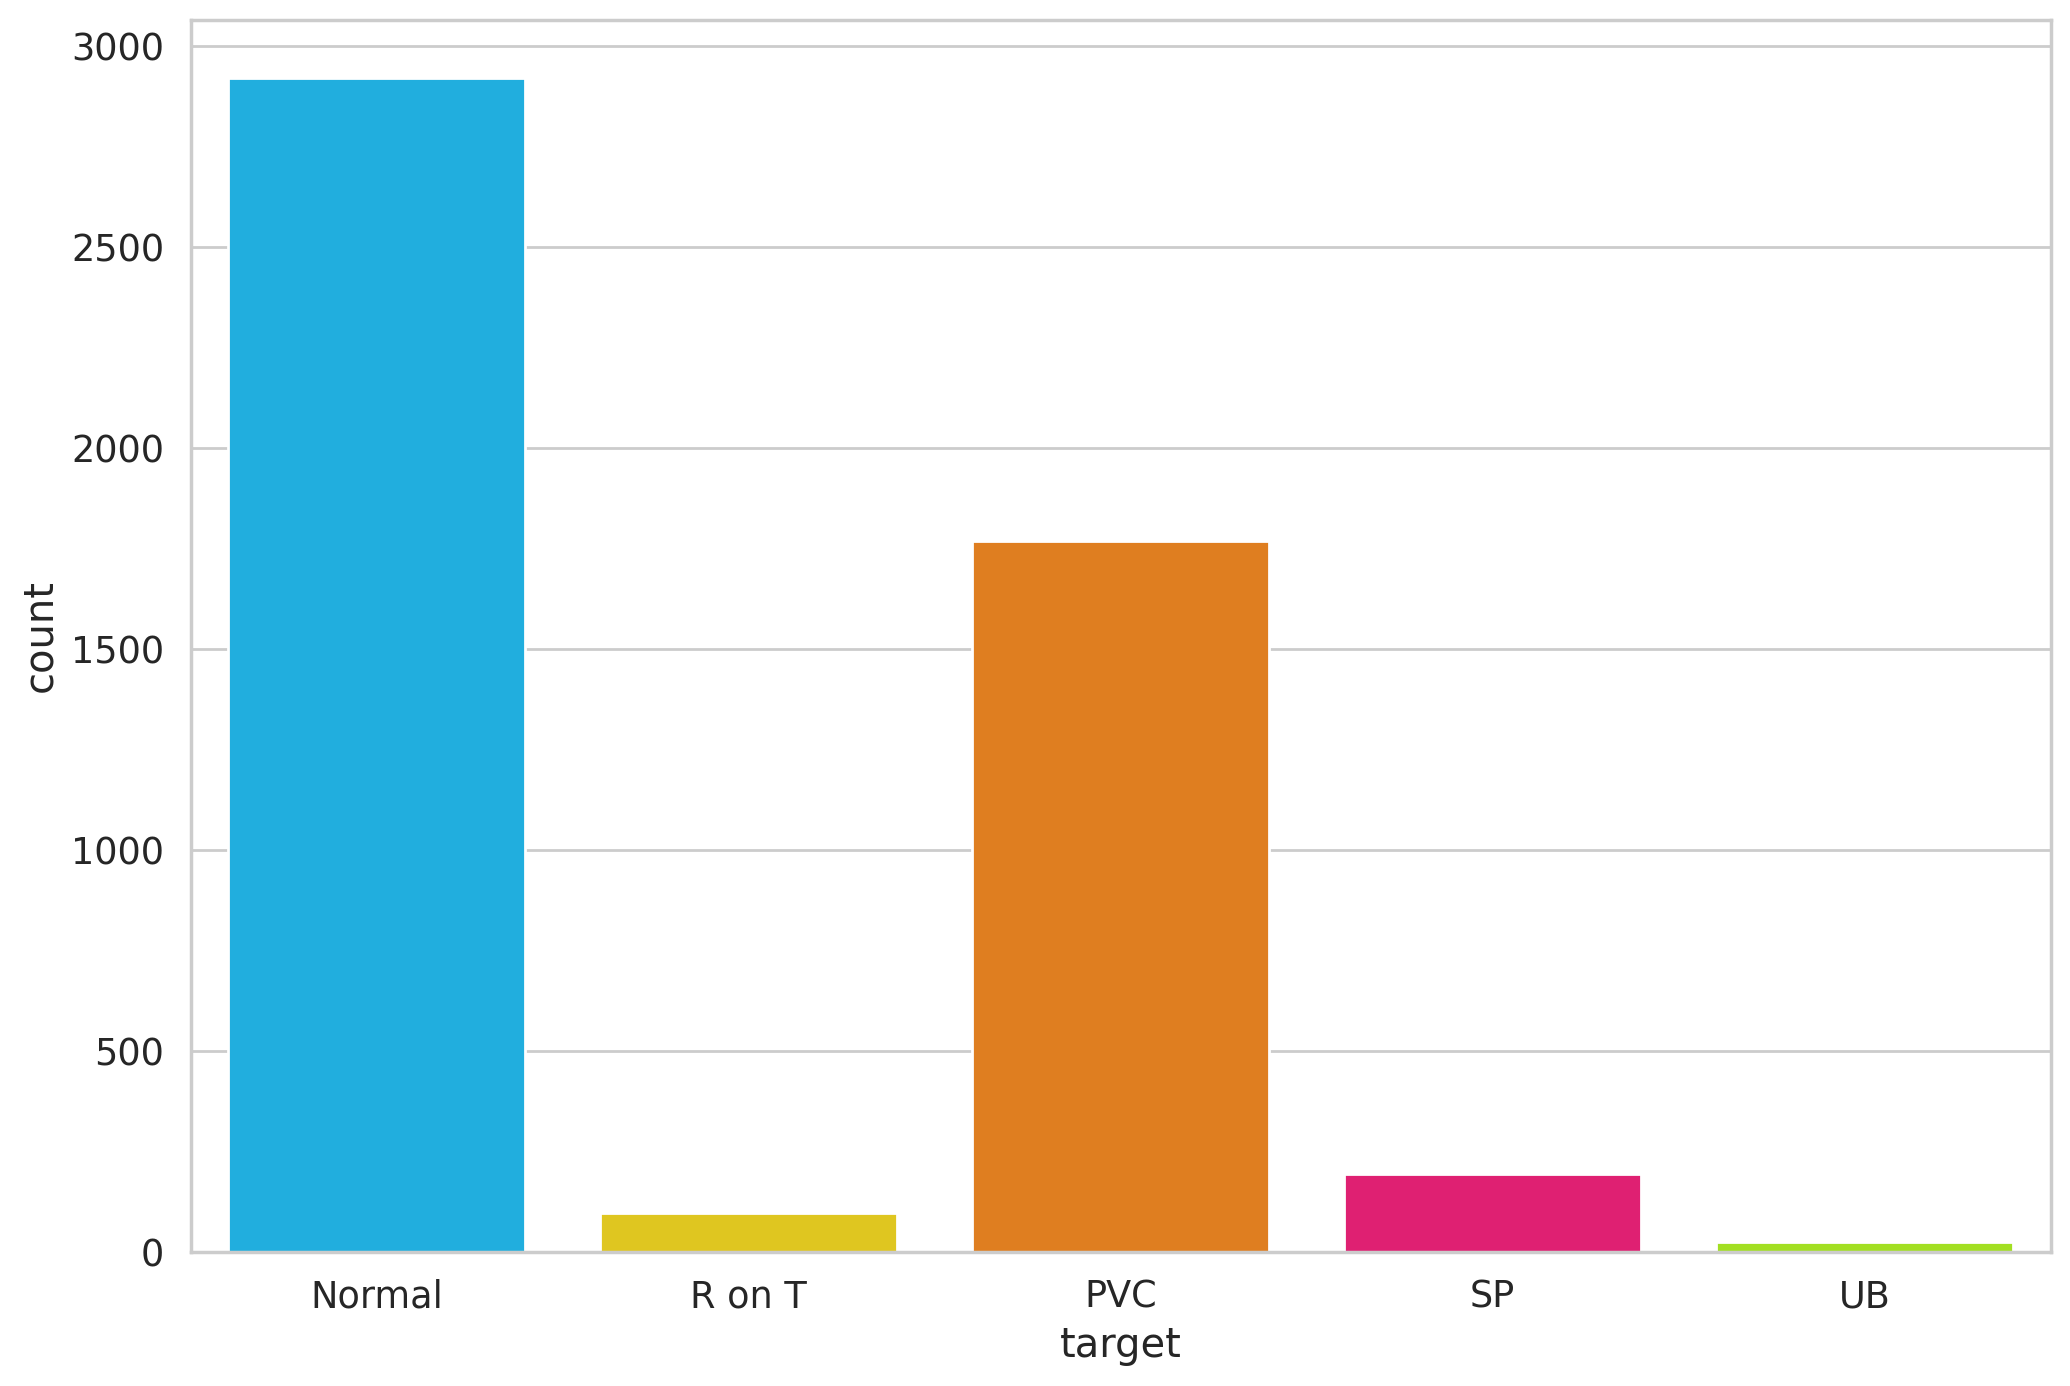

In [13]:
ax = sns.countplot(x=df.target)
ax.set_xticklabels(class_names);

In [14]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

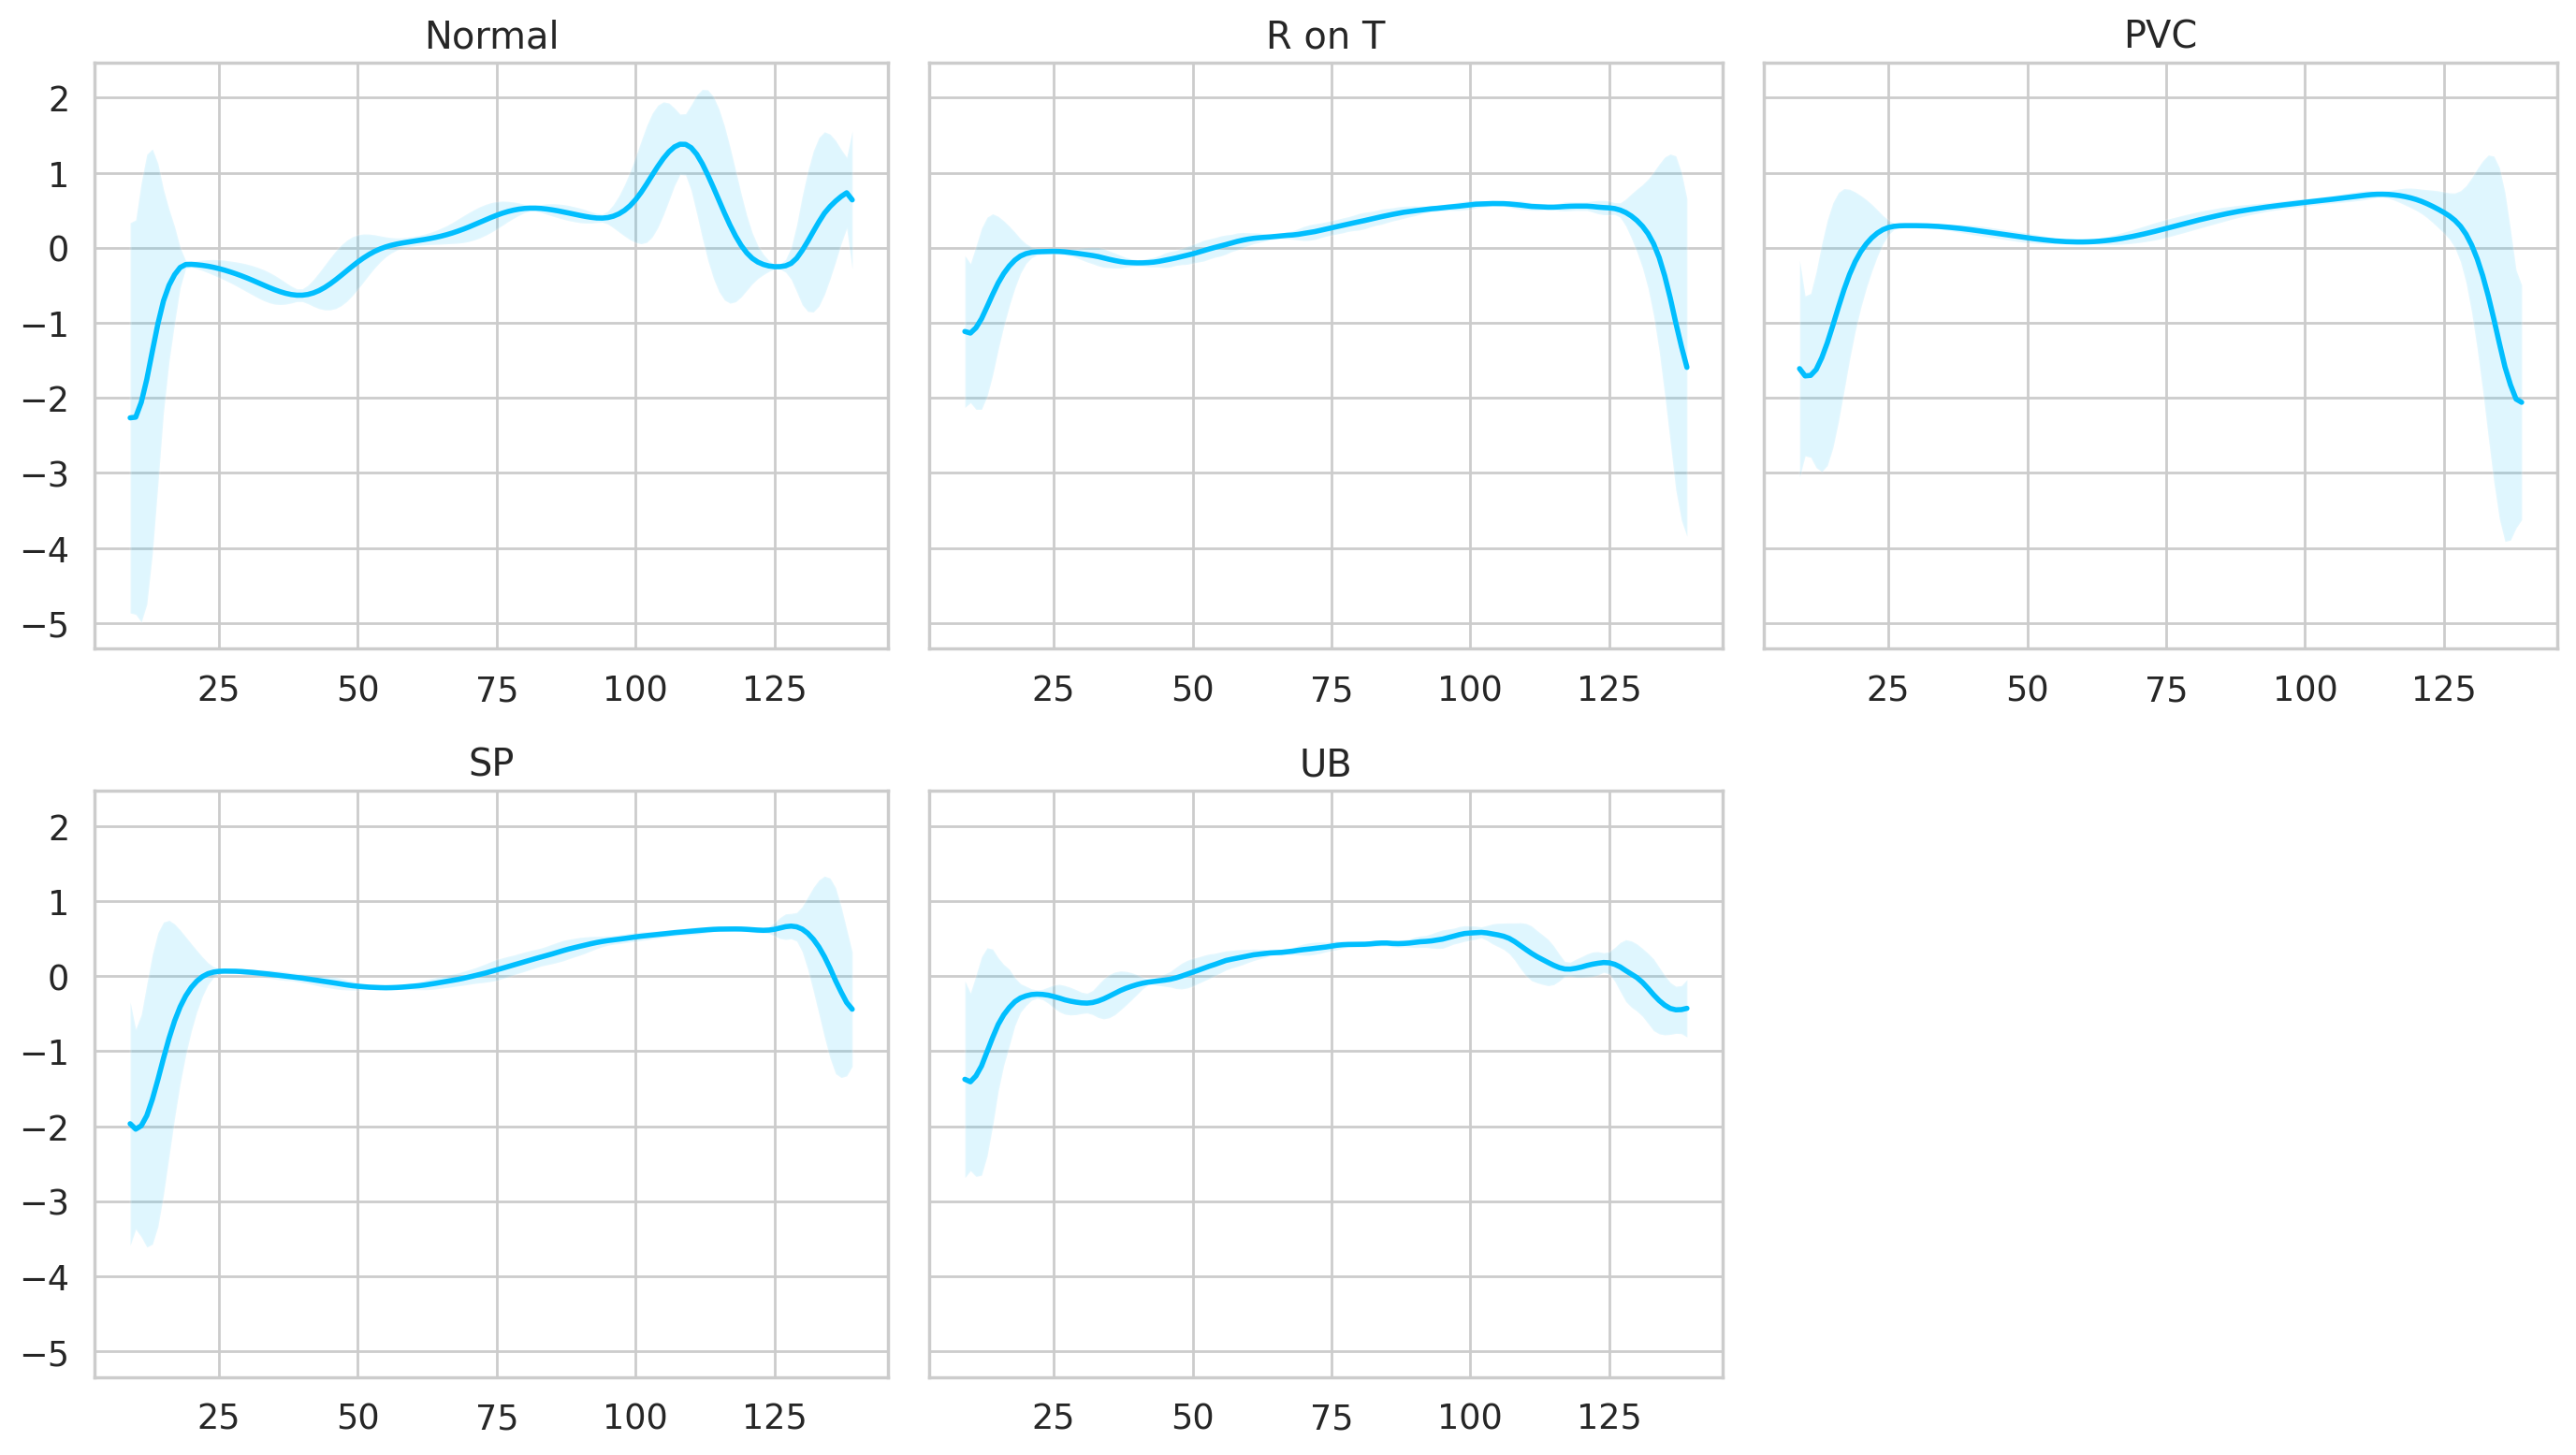

In [15]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

In [16]:
normal_df = df[df.target == b'1'].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

In [17]:
anomaly_df = df[df.target != b'1'].drop(labels='target', axis=1)
anomaly_df.shape

(2081, 140)

In [18]:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33,
  random_state=RANDOM_SEED
)

In [19]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

In [20]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

In [21]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [22]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [23]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [24]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

In [25]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0

  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [26]:
model, history = train_model(
  model,
  train_dataset,
  val_dataset,
  n_epochs=150
)

Epoch 1: train loss 66.04732513812125 val loss 53.568083310696856
Epoch 2: train loss 52.779205385305765 val loss 60.44438466928111
Epoch 3: train loss 49.967706261311555 val loss 45.99064168832408
Epoch 4: train loss 39.10792704447293 val loss 37.31256419888128
Epoch 5: train loss 35.02392430557257 val loss 32.23329028822863
Epoch 6: train loss 32.028894622784286 val loss 31.12712437951931
Epoch 7: train loss 28.35933726547899 val loss 27.31946917198624
Epoch 8: train loss 26.678416552345677 val loss 24.98950033545901
Epoch 9: train loss 26.051449151829047 val loss 25.84633122532034
Epoch 10: train loss 25.21627584977863 val loss 23.061454704597136
Epoch 11: train loss 24.73415016810868 val loss 24.816704486417283
Epoch 12: train loss 24.611163433786842 val loss 25.964055656979923
Epoch 13: train loss 22.74400144390212 val loss 21.30149521681229
Epoch 14: train loss 21.140040373811797 val loss 21.884032597720825
Epoch 15: train loss 20.013450647544015 val loss 21.051916639959448
Epoch

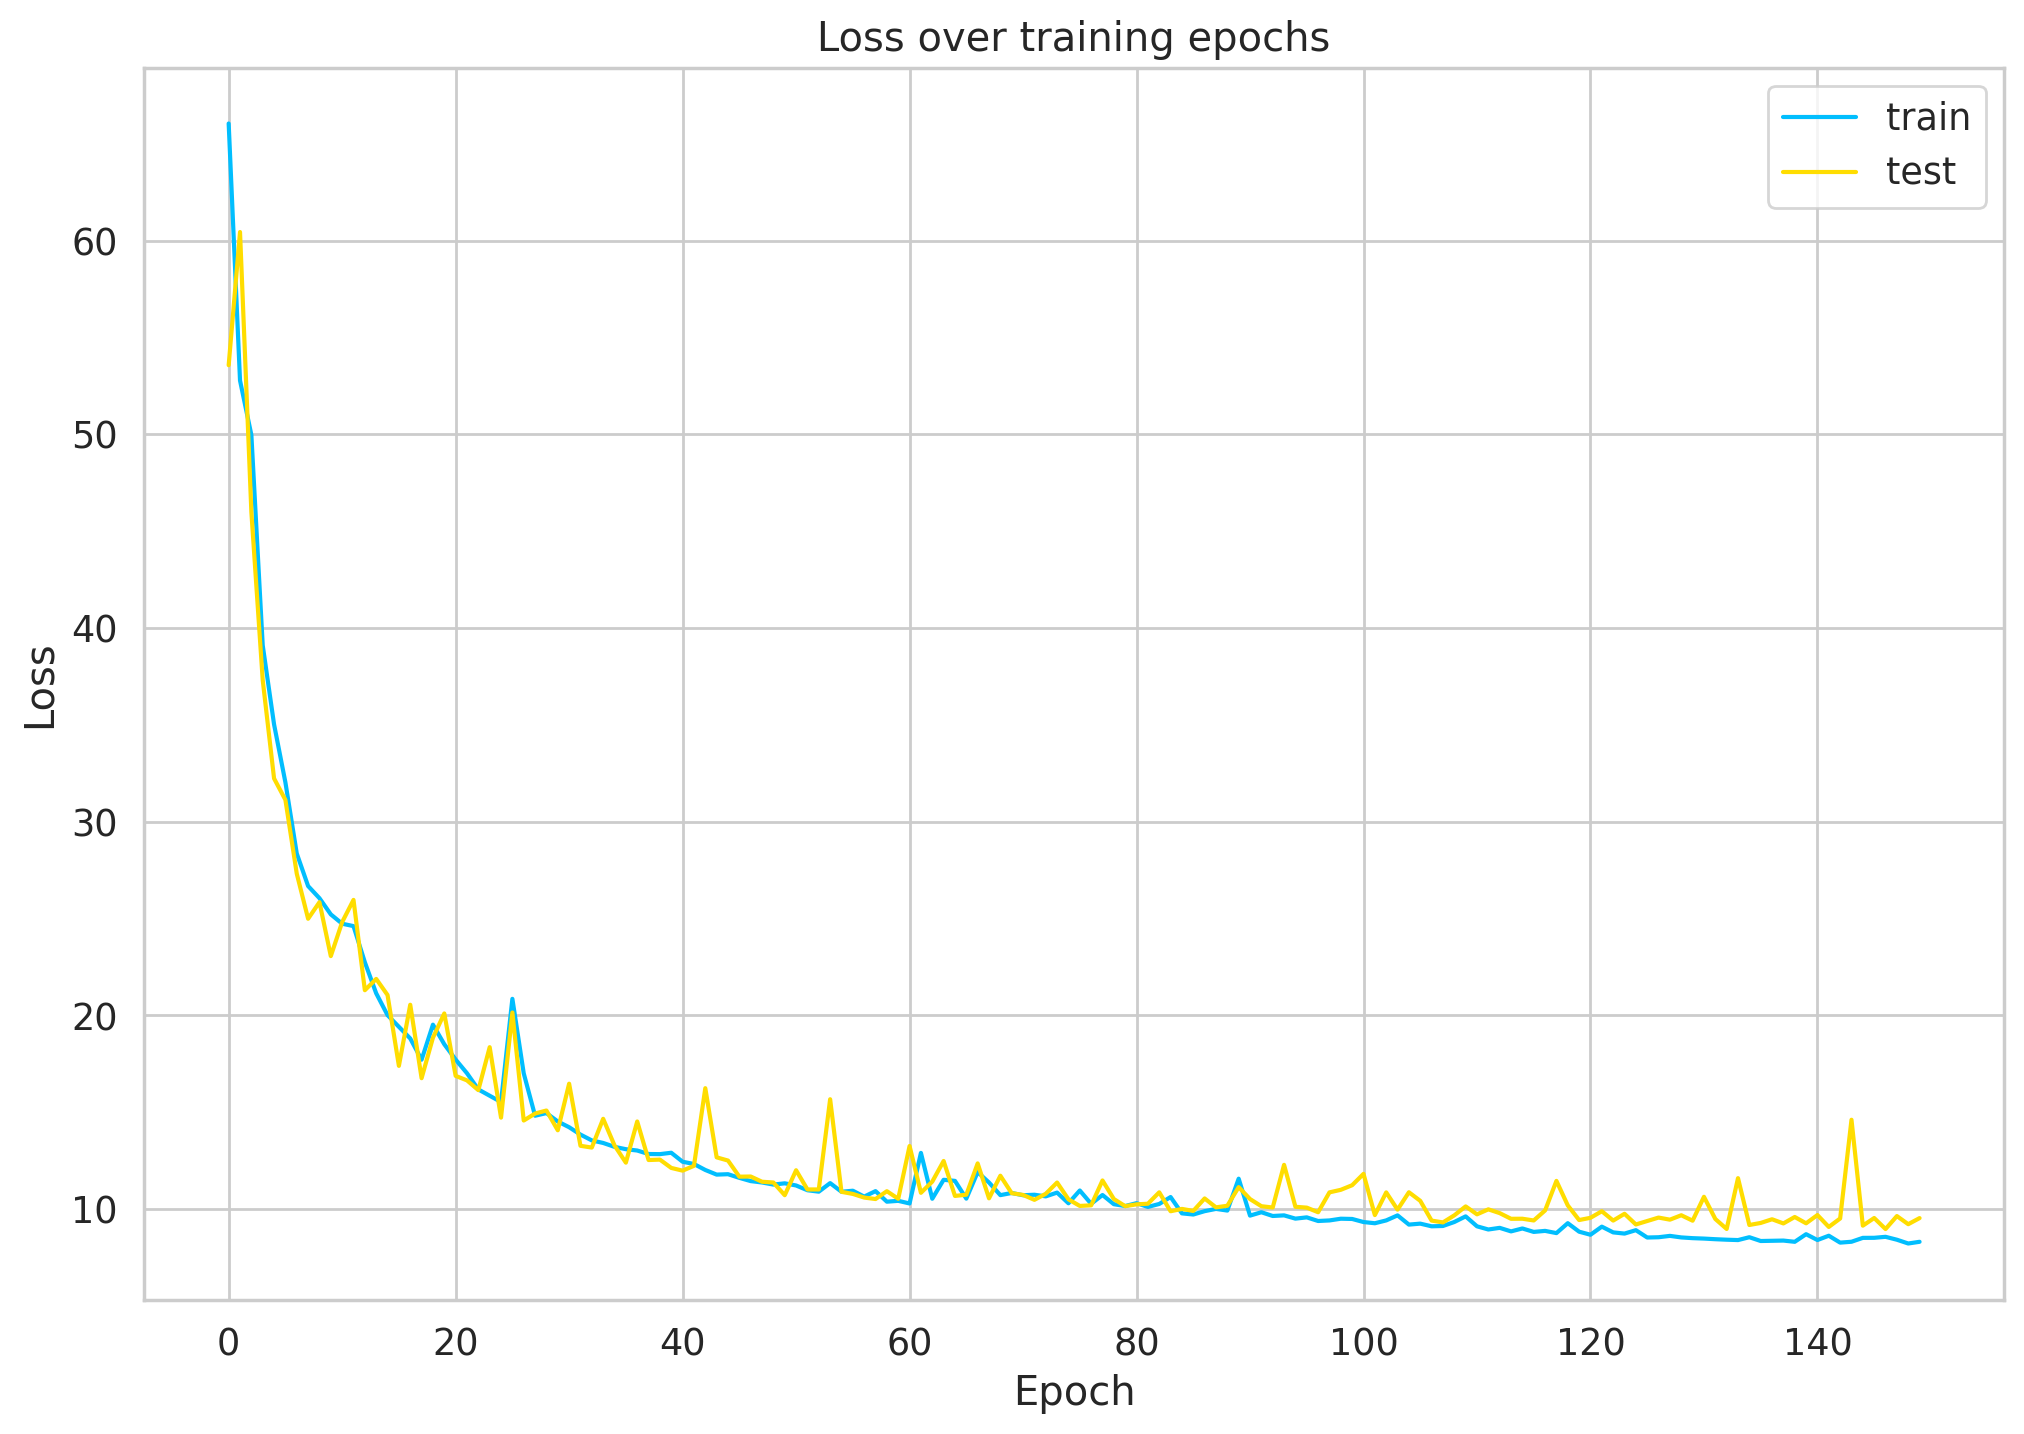

In [27]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [28]:
MODEL_PATH = 'model.pth'

torch.save(model, MODEL_PATH)

In [29]:
# !gdown --id 14SLk-7tkqwvewhzC9ffmWcsq387IcDaq
# model = torch.load('model.pth')
# model = model.to(device)

In [30]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

<ipython-input-31-78552d7f385f>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(losses, bins=50, kde=True);


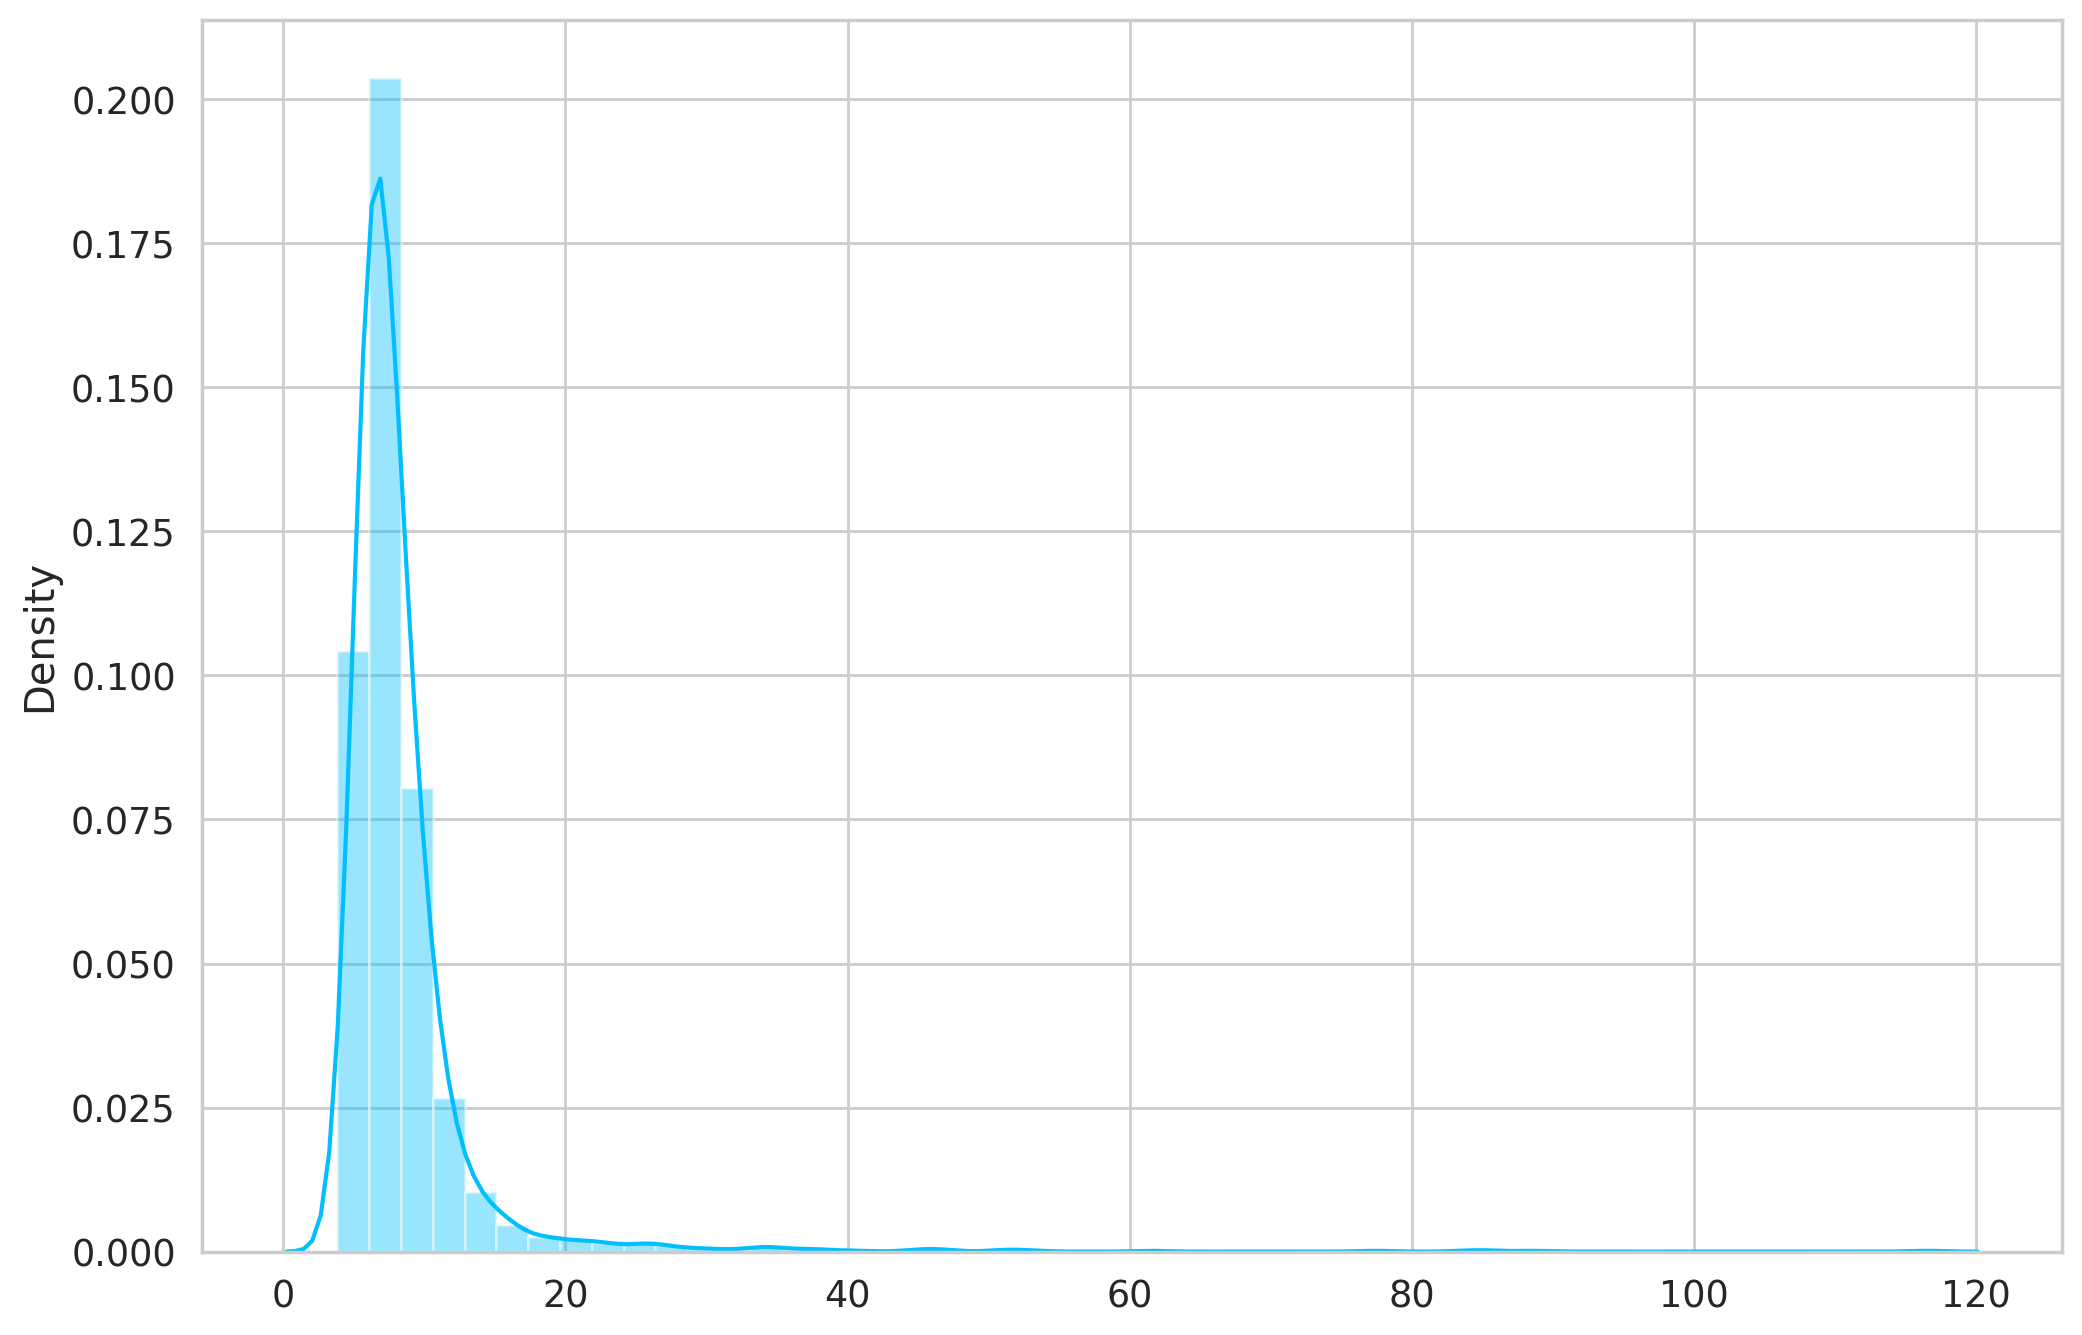

In [31]:
_, losses = predict(model, train_dataset)
sns.distplot(losses, bins=50, kde=True);

In [32]:
THRESHOLD = 26

<ipython-input-33-ed53989f8e41>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True);


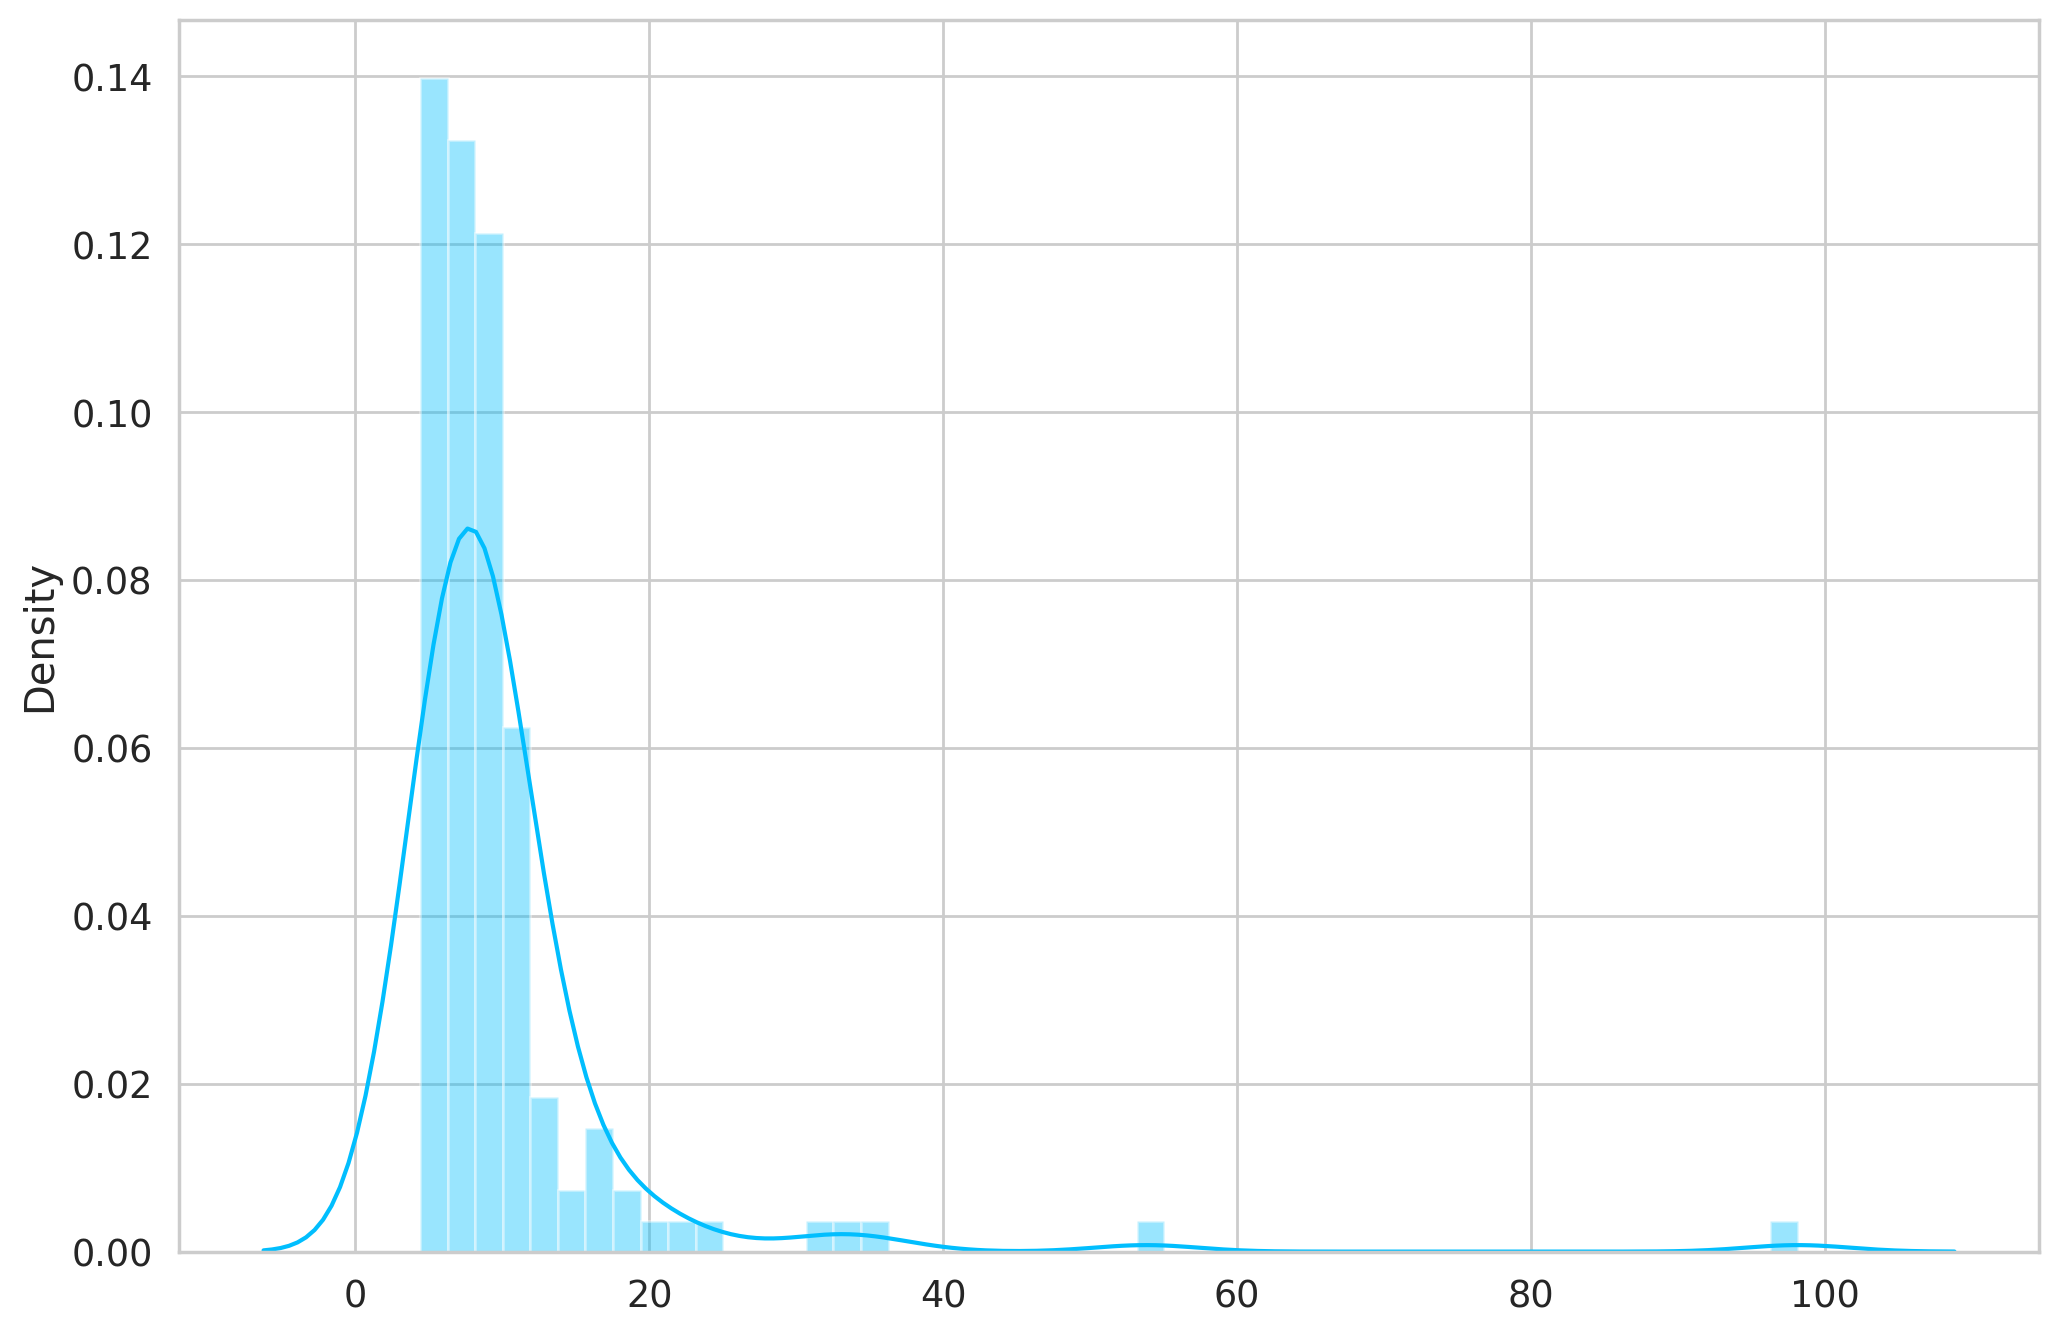

In [33]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [34]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 140/145


In [35]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

<ipython-input-36-ad94685d44b0>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True);


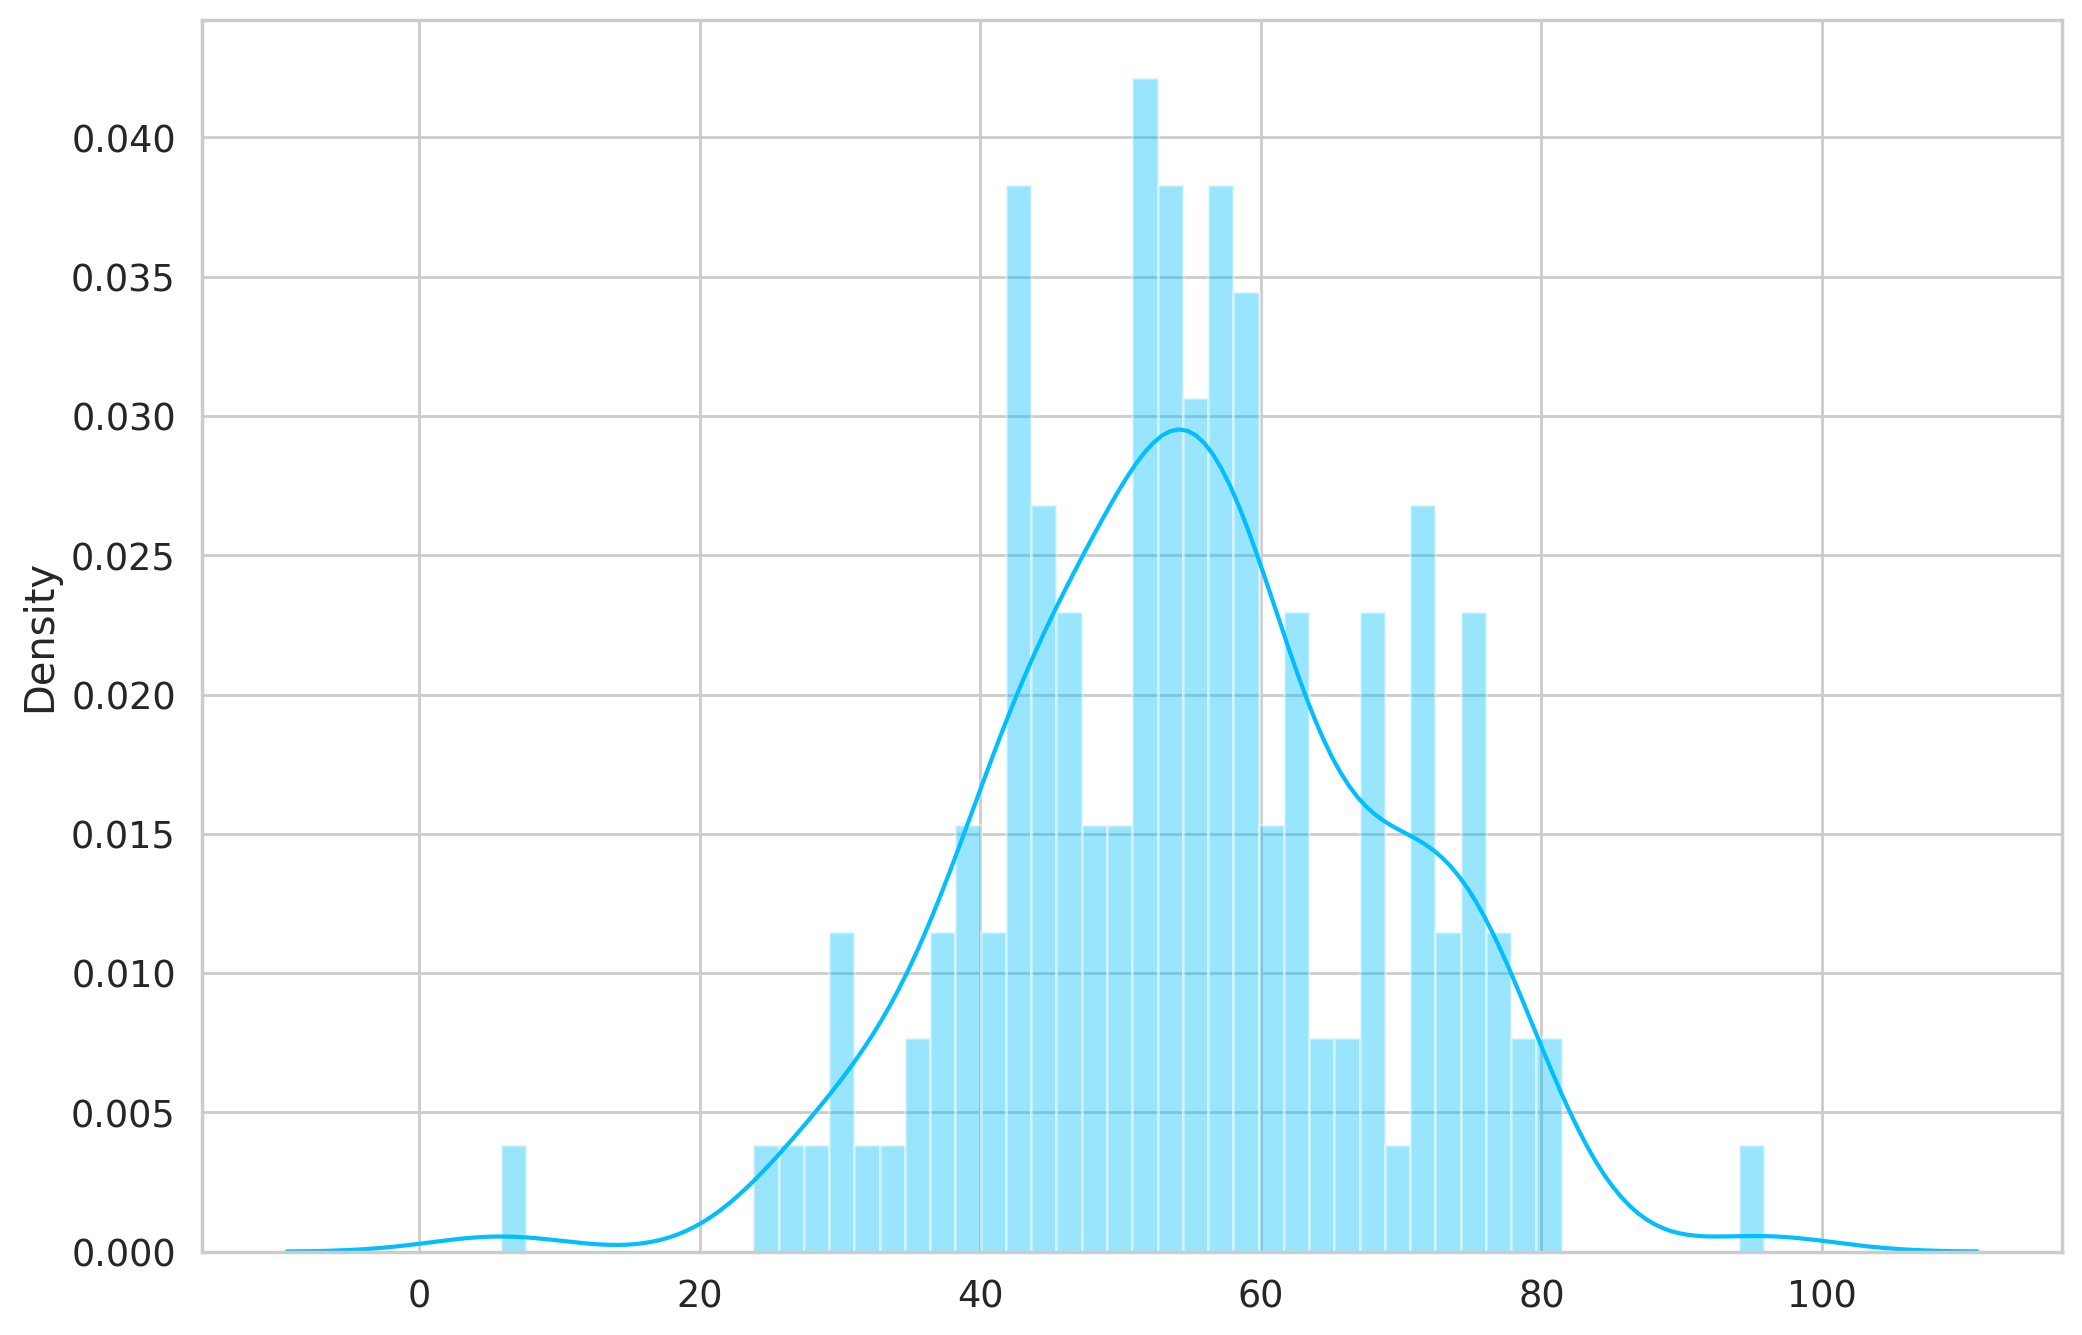

In [36]:
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [37]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct anomaly predictions: 143/145


In [38]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

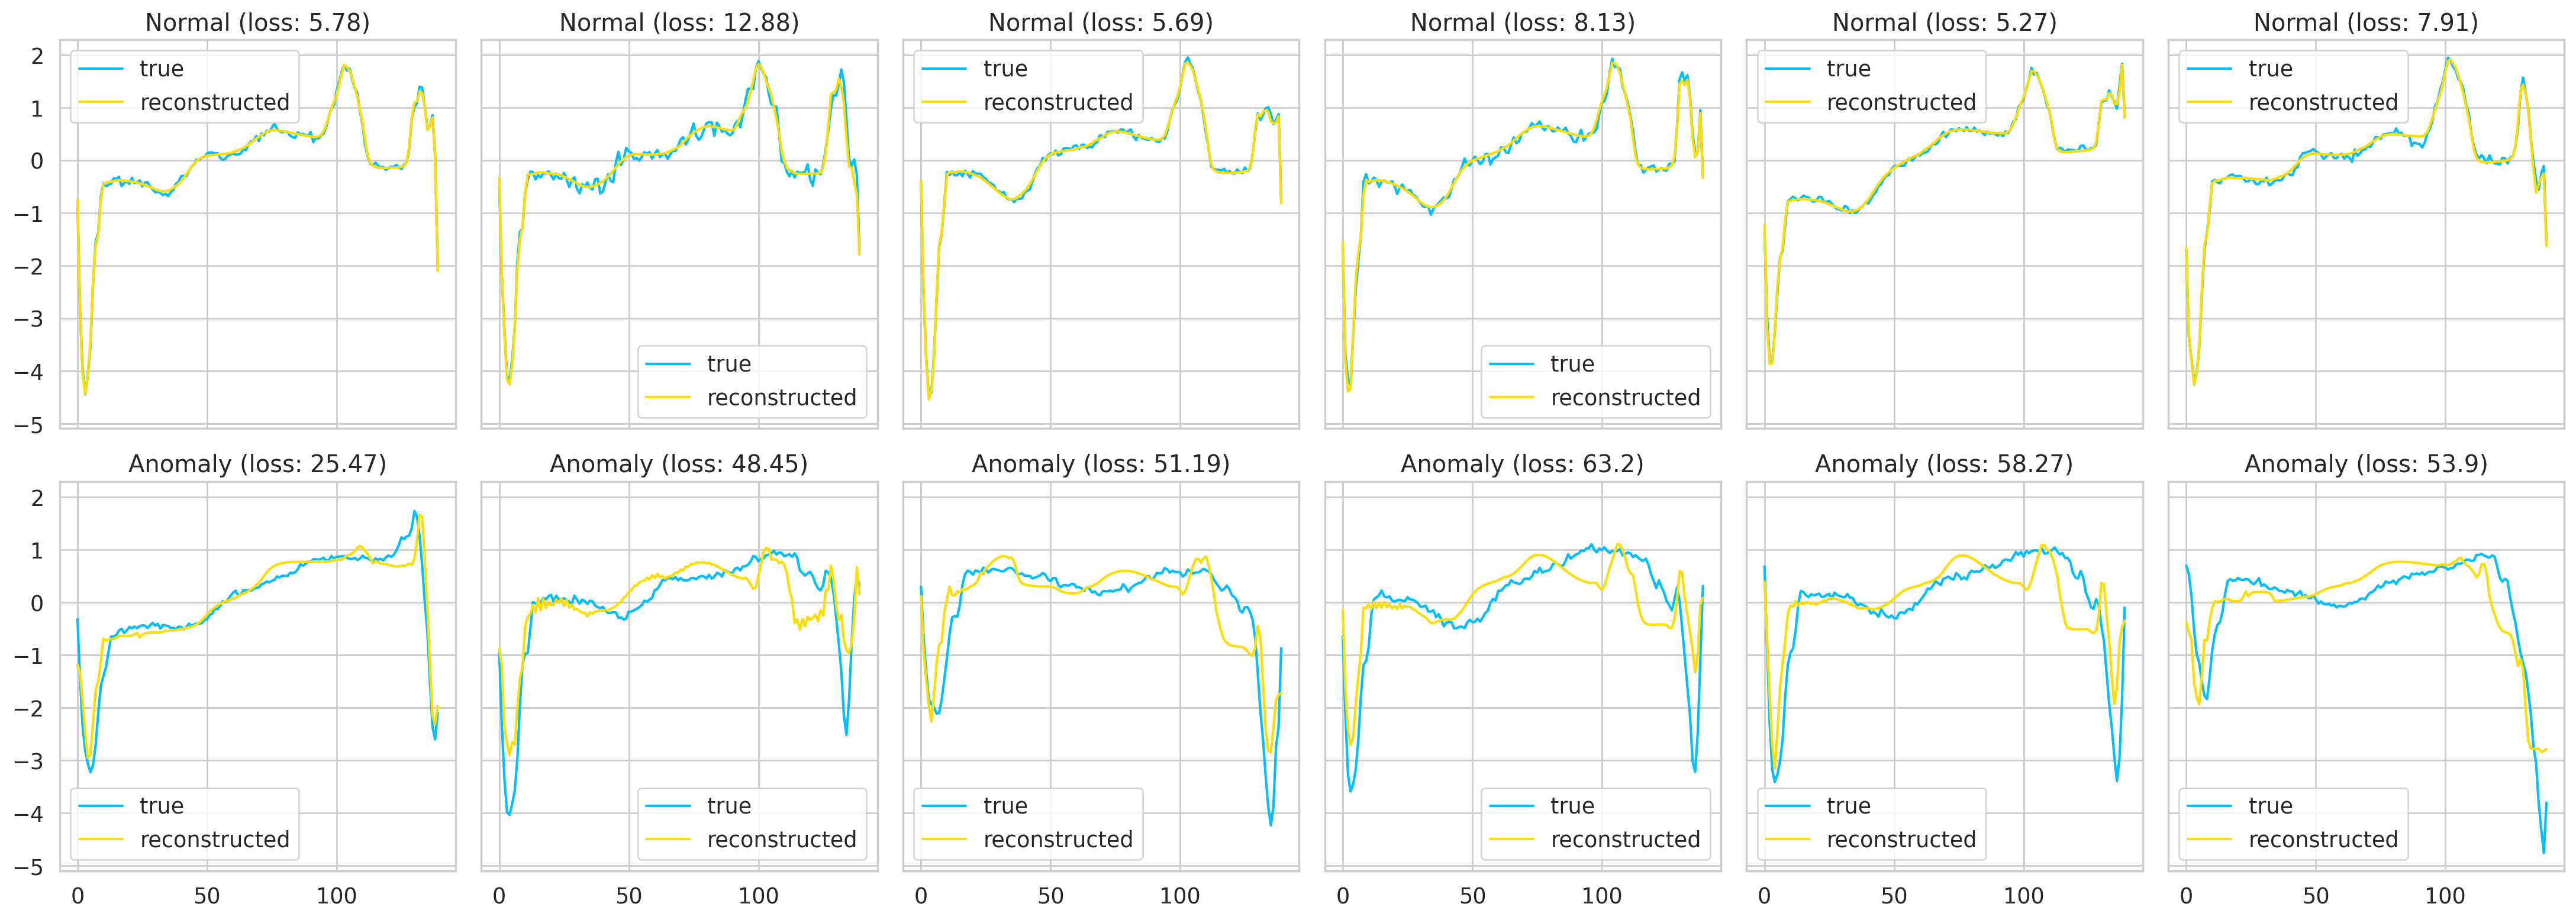

In [39]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();

In [40]:
RNT_df = df[df.target == b'2'].drop(labels='target', axis=1)
RNT_df.shape

(1767, 140)

In [41]:
anomaly_df = df[df.target != b'2'].drop(labels='target', axis=1)
anomaly_df.shape

(3233, 140)

In [42]:
train_df, val_df = train_test_split(
  RNT_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33,
  random_state=RANDOM_SEED
)

In [43]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

In [44]:
model_RNT = RecurrentAutoencoder(seq_len, n_features, 128)
model_RNT = model_RNT.to(device)

In [45]:
model_RNT, history = train_model(
  model_RNT,
  train_dataset,
  val_dataset,
  n_epochs=150
)

Epoch 1: train loss 72.19492100430361 val loss 66.79783598224769
Epoch 2: train loss 65.43481209467126 val loss 64.44905186771007
Epoch 3: train loss 64.11457081590788 val loss 63.106387727716
Epoch 4: train loss 61.89350418660102 val loss 62.69569542702664
Epoch 5: train loss 61.067658968880366 val loss 61.554947756649405
Epoch 6: train loss 61.22565828713475 val loss 53.21691258034009
Epoch 7: train loss 53.65474702452597 val loss 44.95016617721386
Epoch 8: train loss 46.7258422325485 val loss 49.40998201691703
Epoch 9: train loss 45.583300931703086 val loss 51.59584843710567
Epoch 10: train loss 44.97421355504818 val loss 46.109733131494416
Epoch 11: train loss 44.64222039102634 val loss 46.17435609624627
Epoch 12: train loss 44.52198358697148 val loss 49.24443776419993
Epoch 13: train loss 44.69091861681649 val loss 45.34383285179567
Epoch 14: train loss 44.518321098922335 val loss 44.90295462661915
Epoch 15: train loss 44.352065646116294 val loss 45.83386078309477
Epoch 16: train 

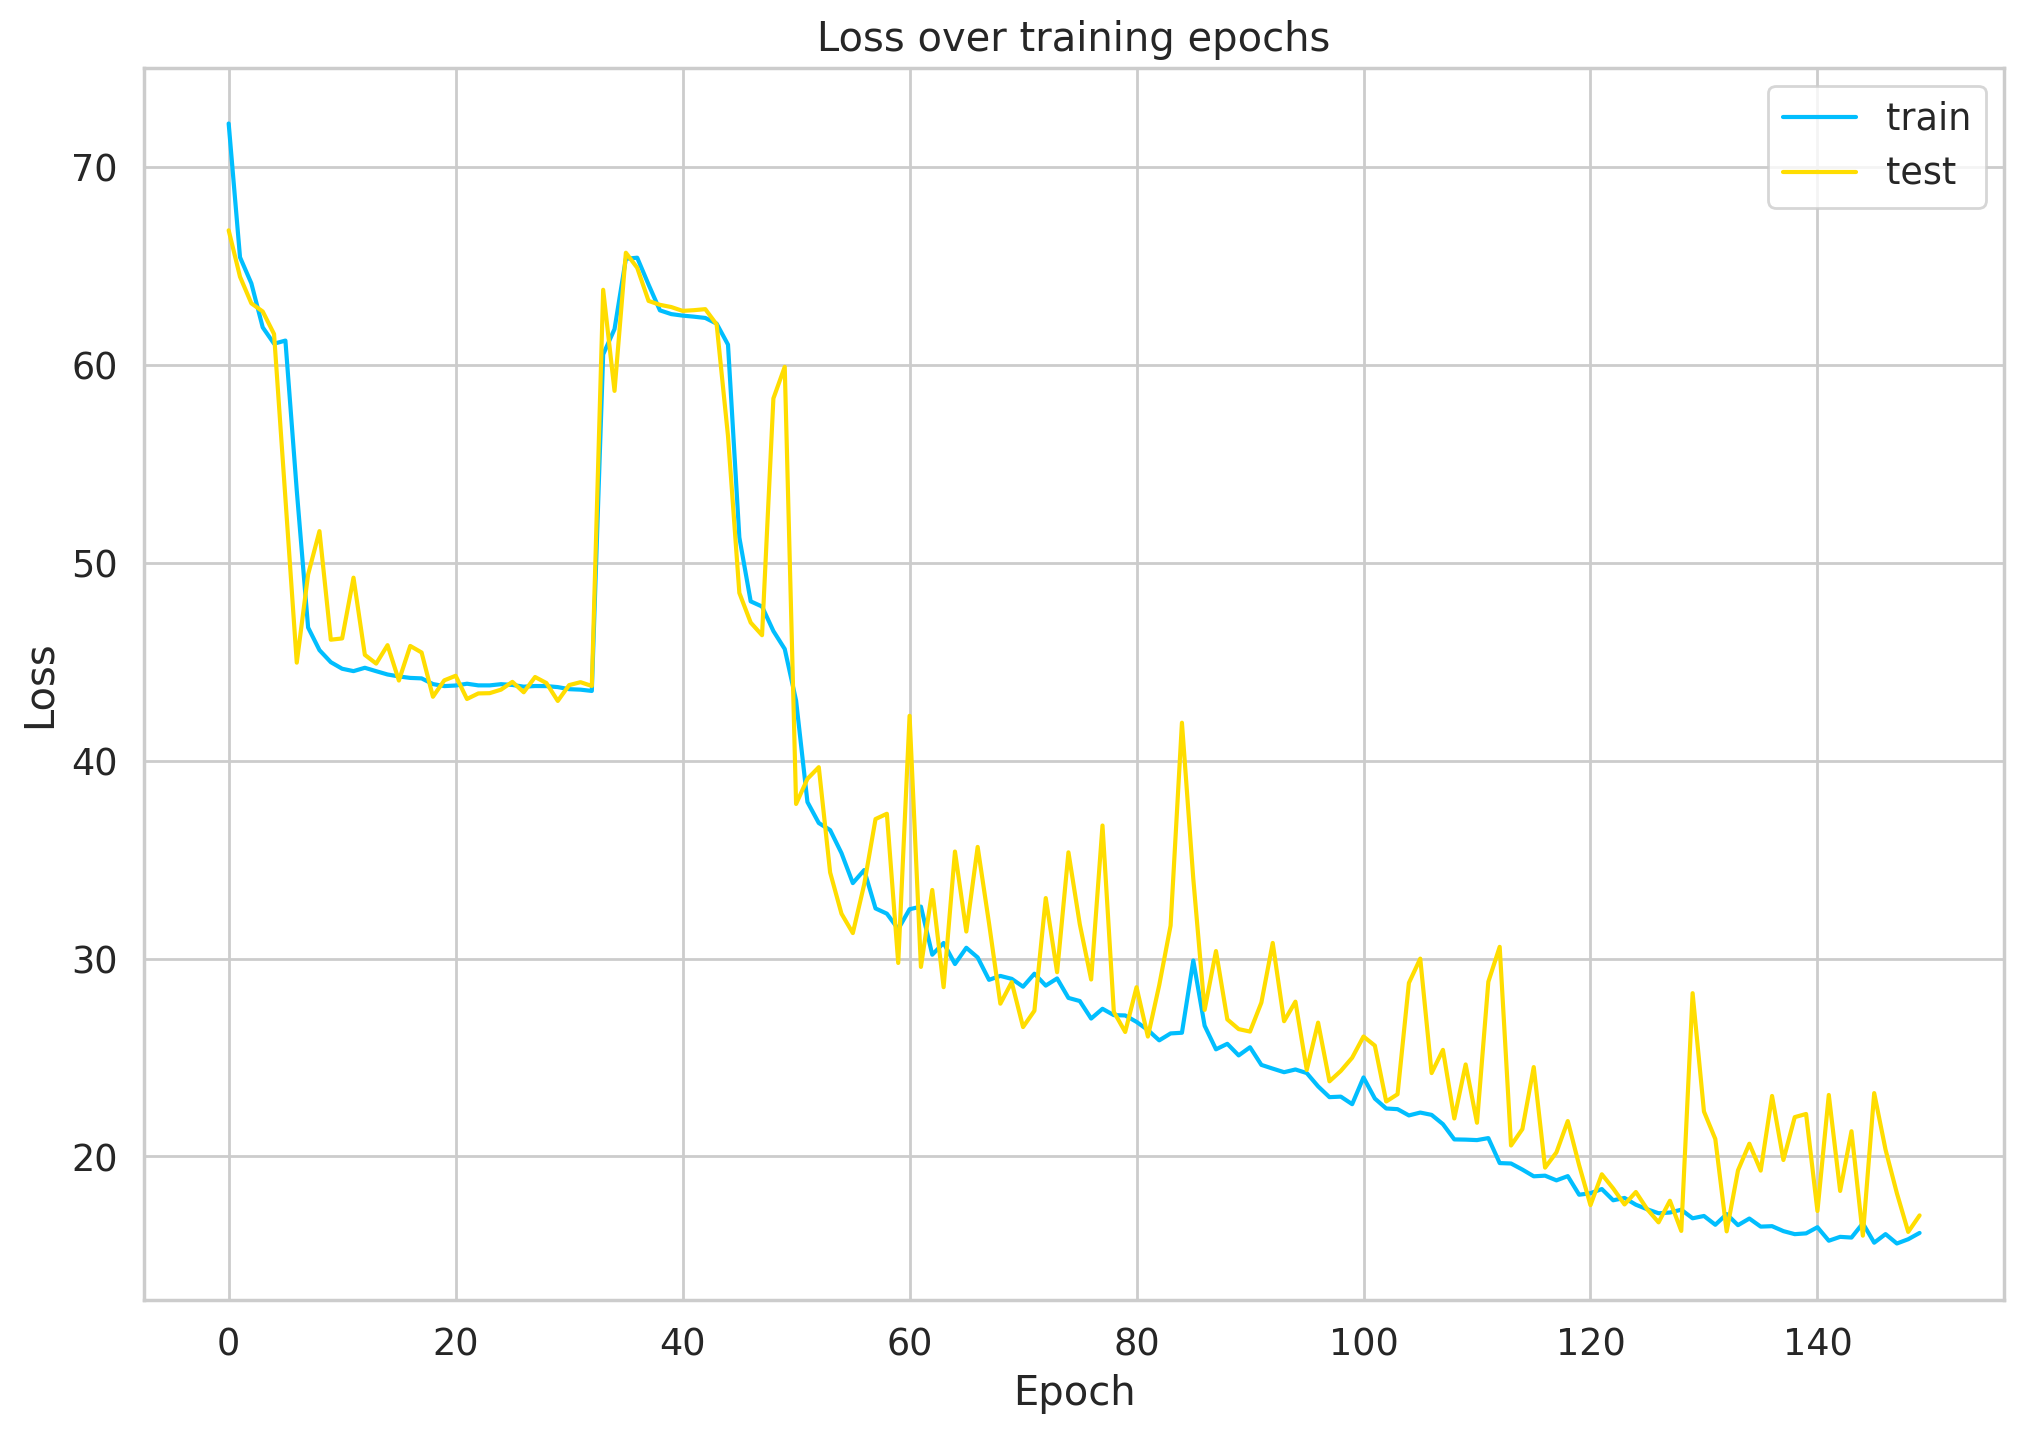

In [46]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [47]:
MODEL_RNT_PATH = 'model_RNT.pth'

torch.save(model_RNT, MODEL_RNT_PATH)

In [48]:
# !gdown --id 1i0T9horNTjAjf4fw1aL3BkNpS-FoEFVG
# model_RNT = torch.load('model_RNT.pth')
# model_RNT = model_RNT.to(device)

<ipython-input-49-73a8c67a8f7b>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(losses, bins=50, kde=True);


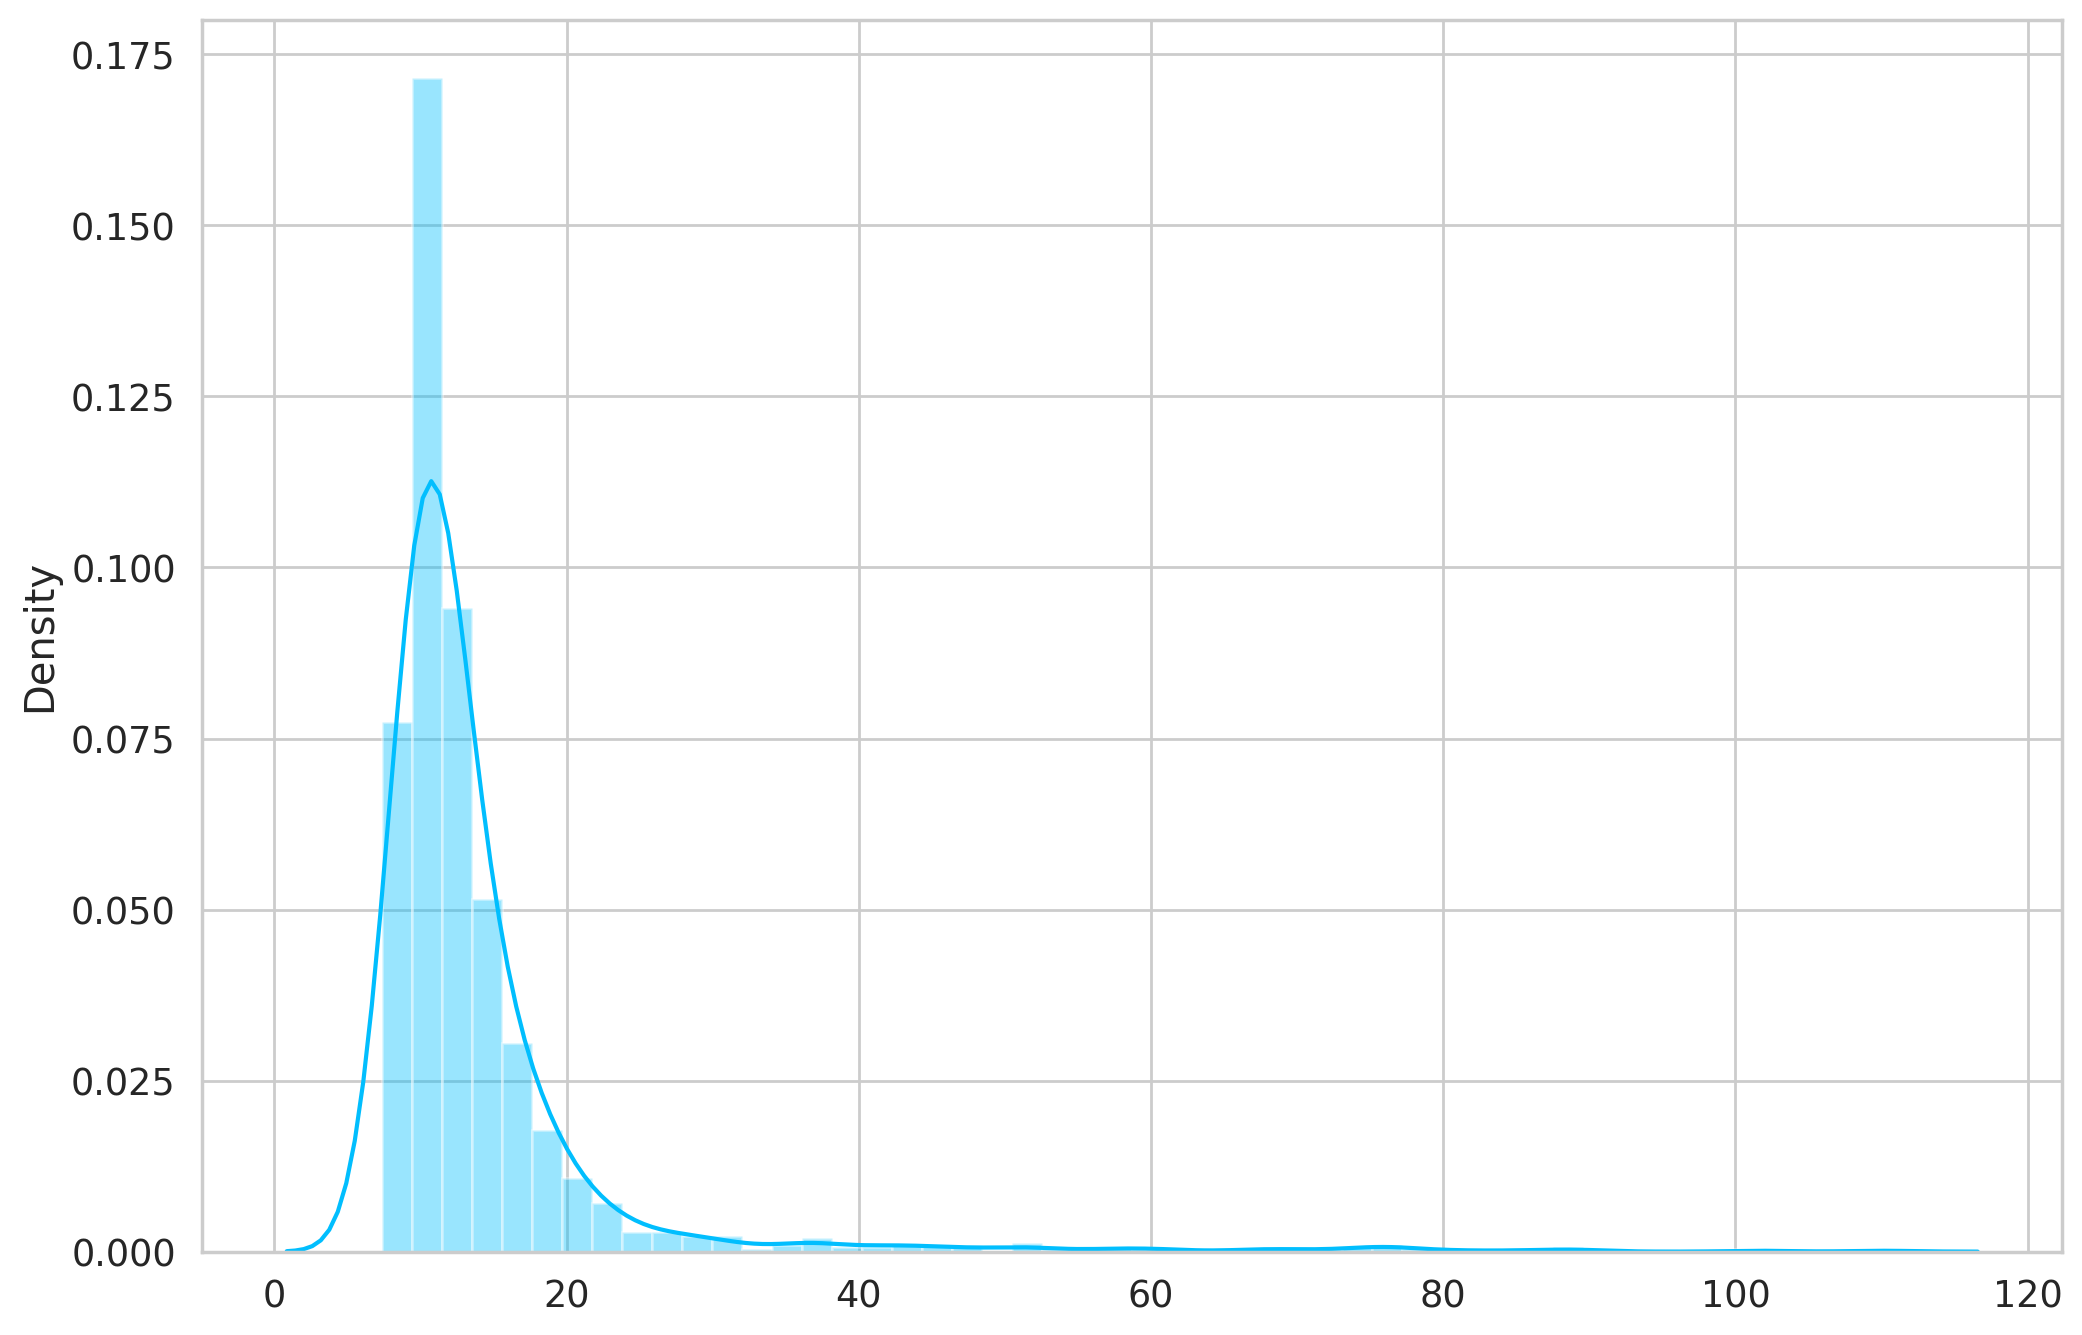

In [49]:
_, losses = predict(model_RNT, train_dataset)
sns.distplot(losses, bins=50, kde=True);

In [50]:
THRESHOLD = 36

<ipython-input-51-b8cc77d092c0>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True);


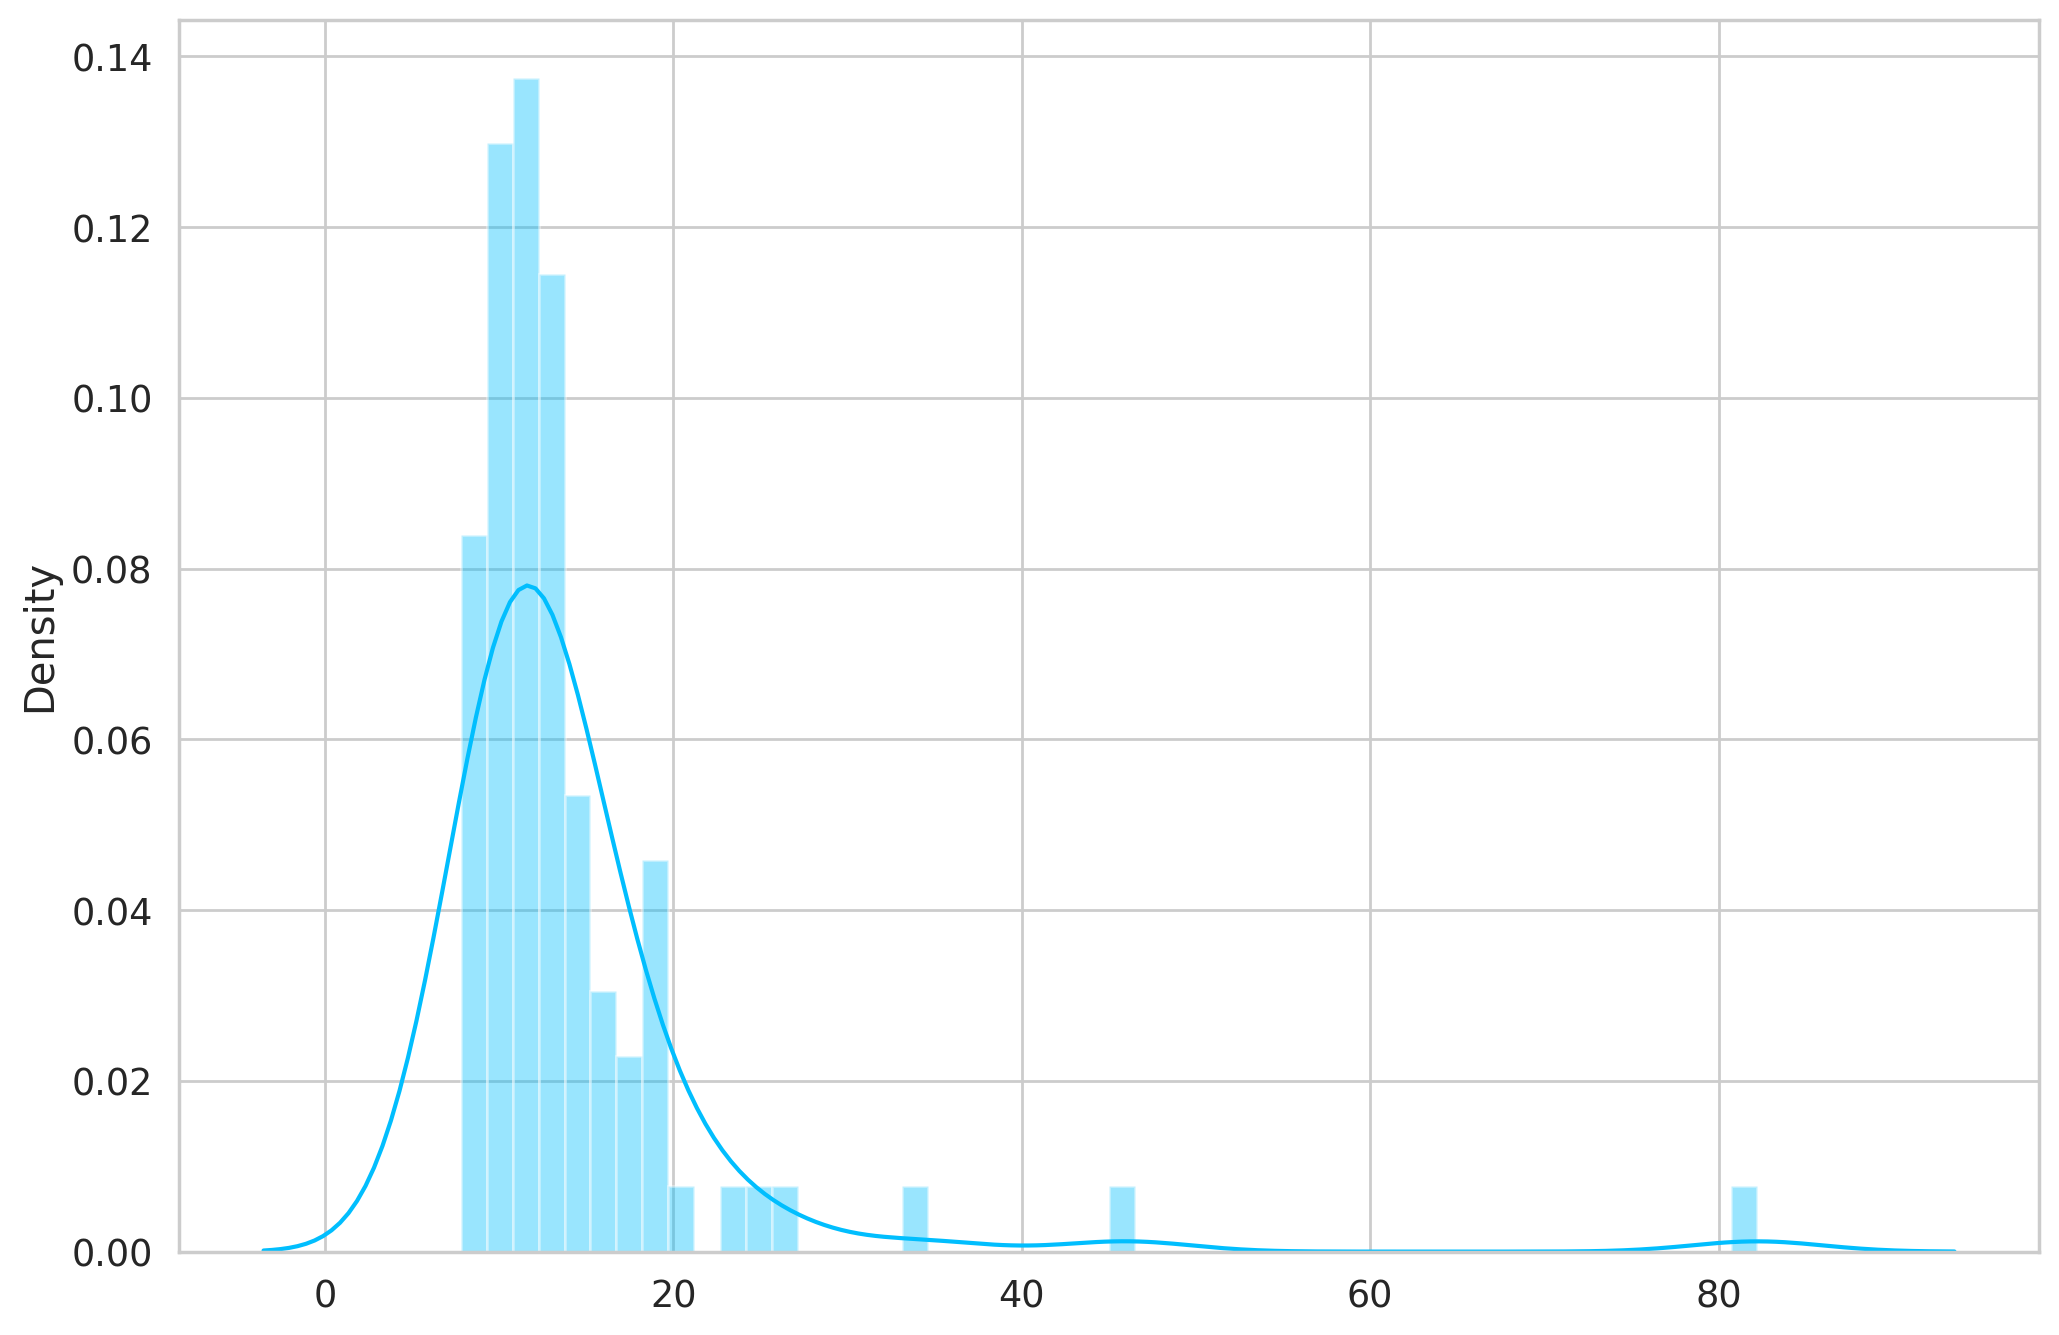

In [51]:
predictions, pred_losses = predict(model_RNT, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [52]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 86/88


In [53]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

<ipython-input-54-4115fcf95dd0>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True);


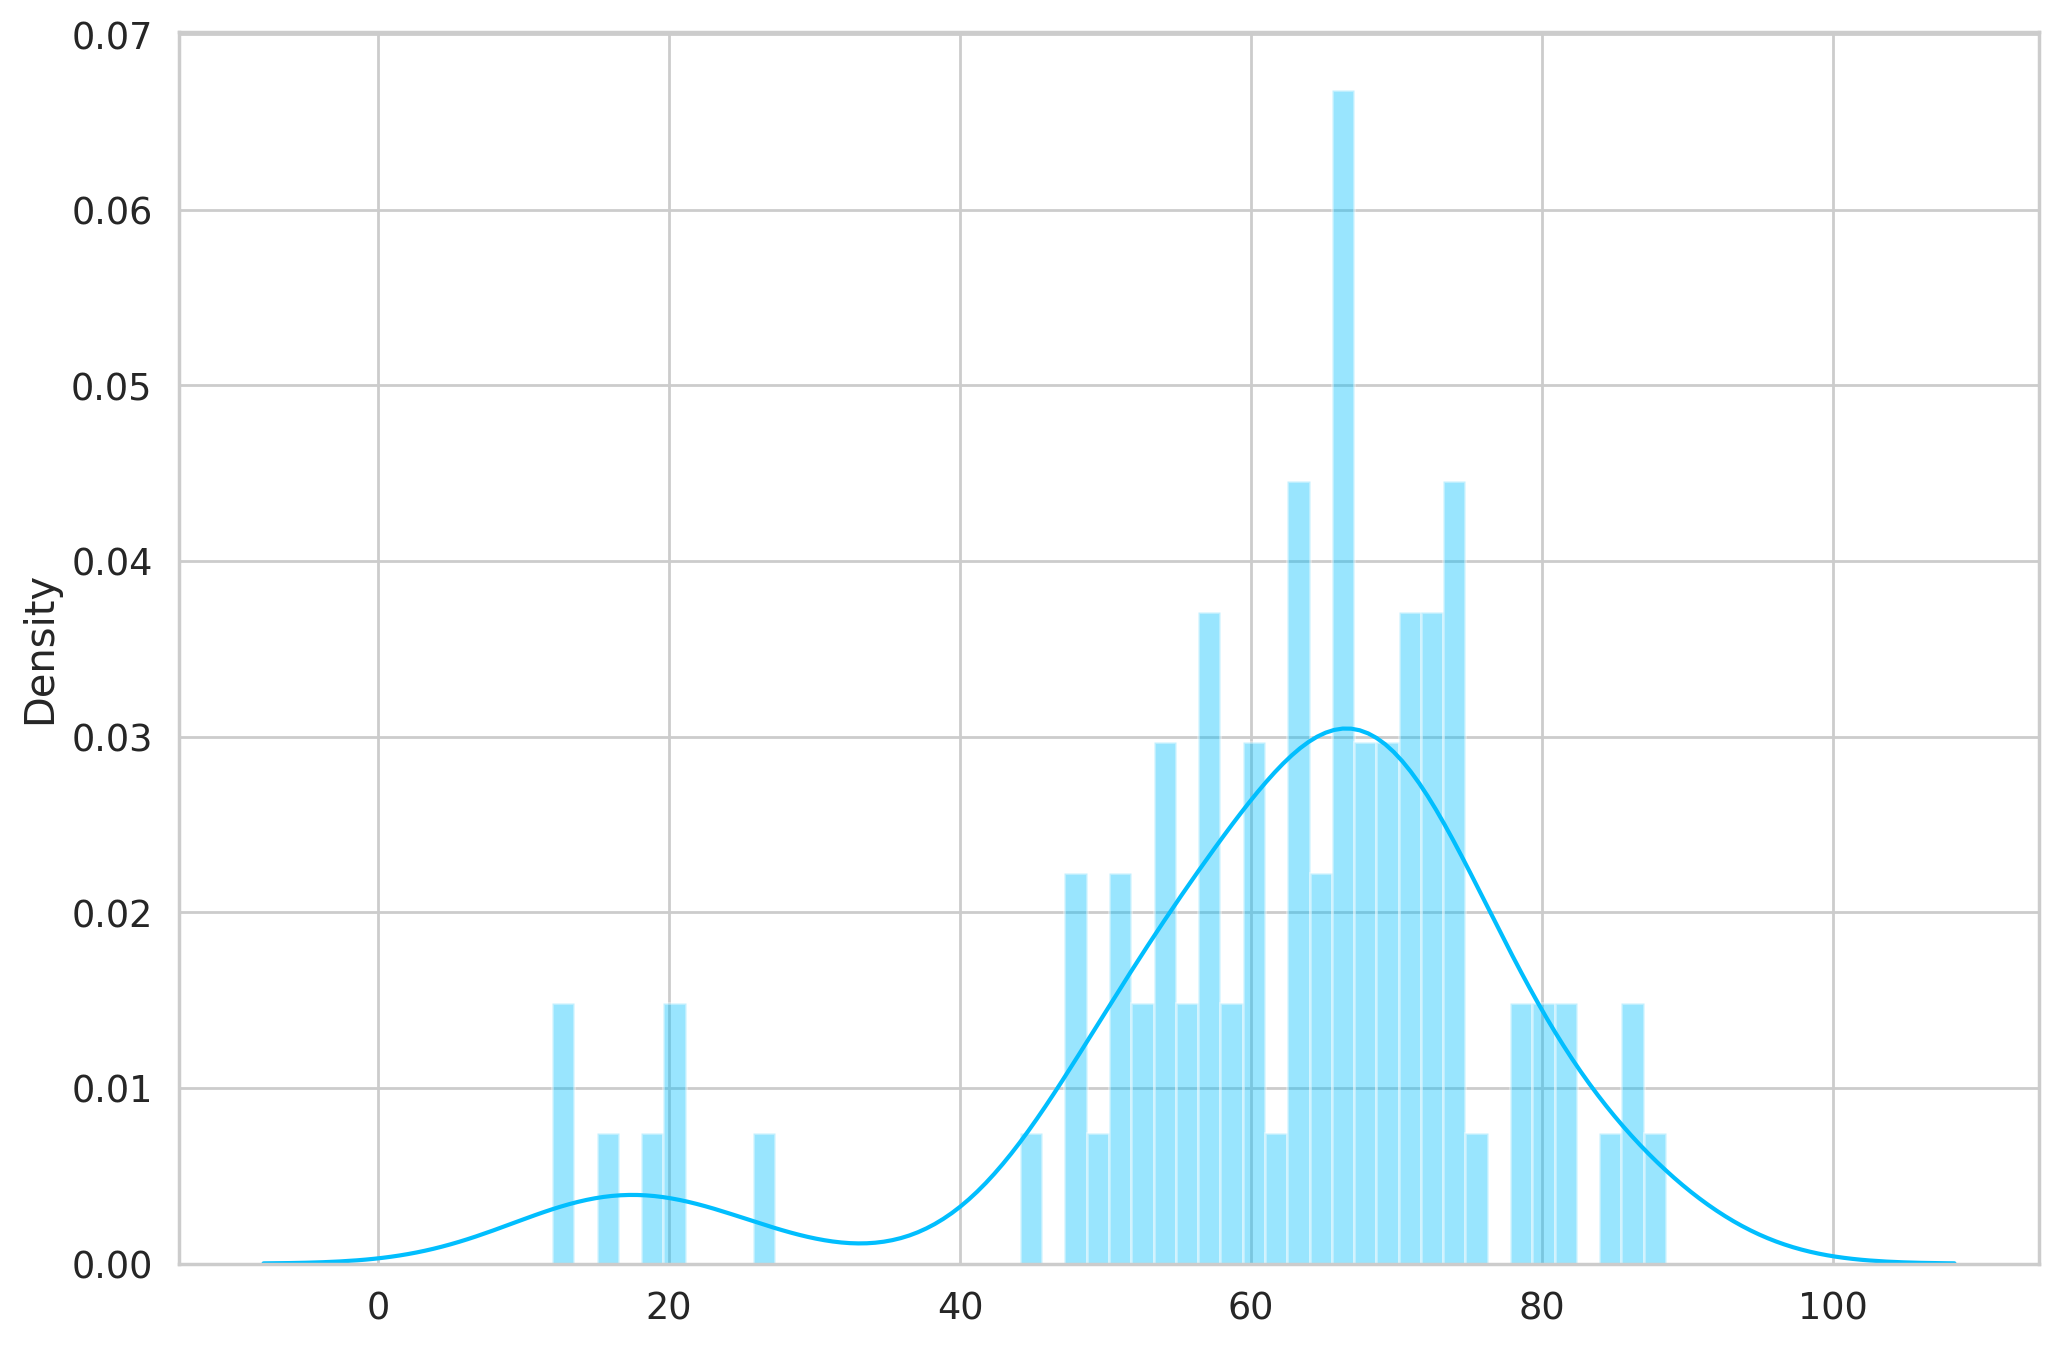

In [54]:
predictions, pred_losses = predict(model_RNT, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [55]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct anomaly predictions: 81/88


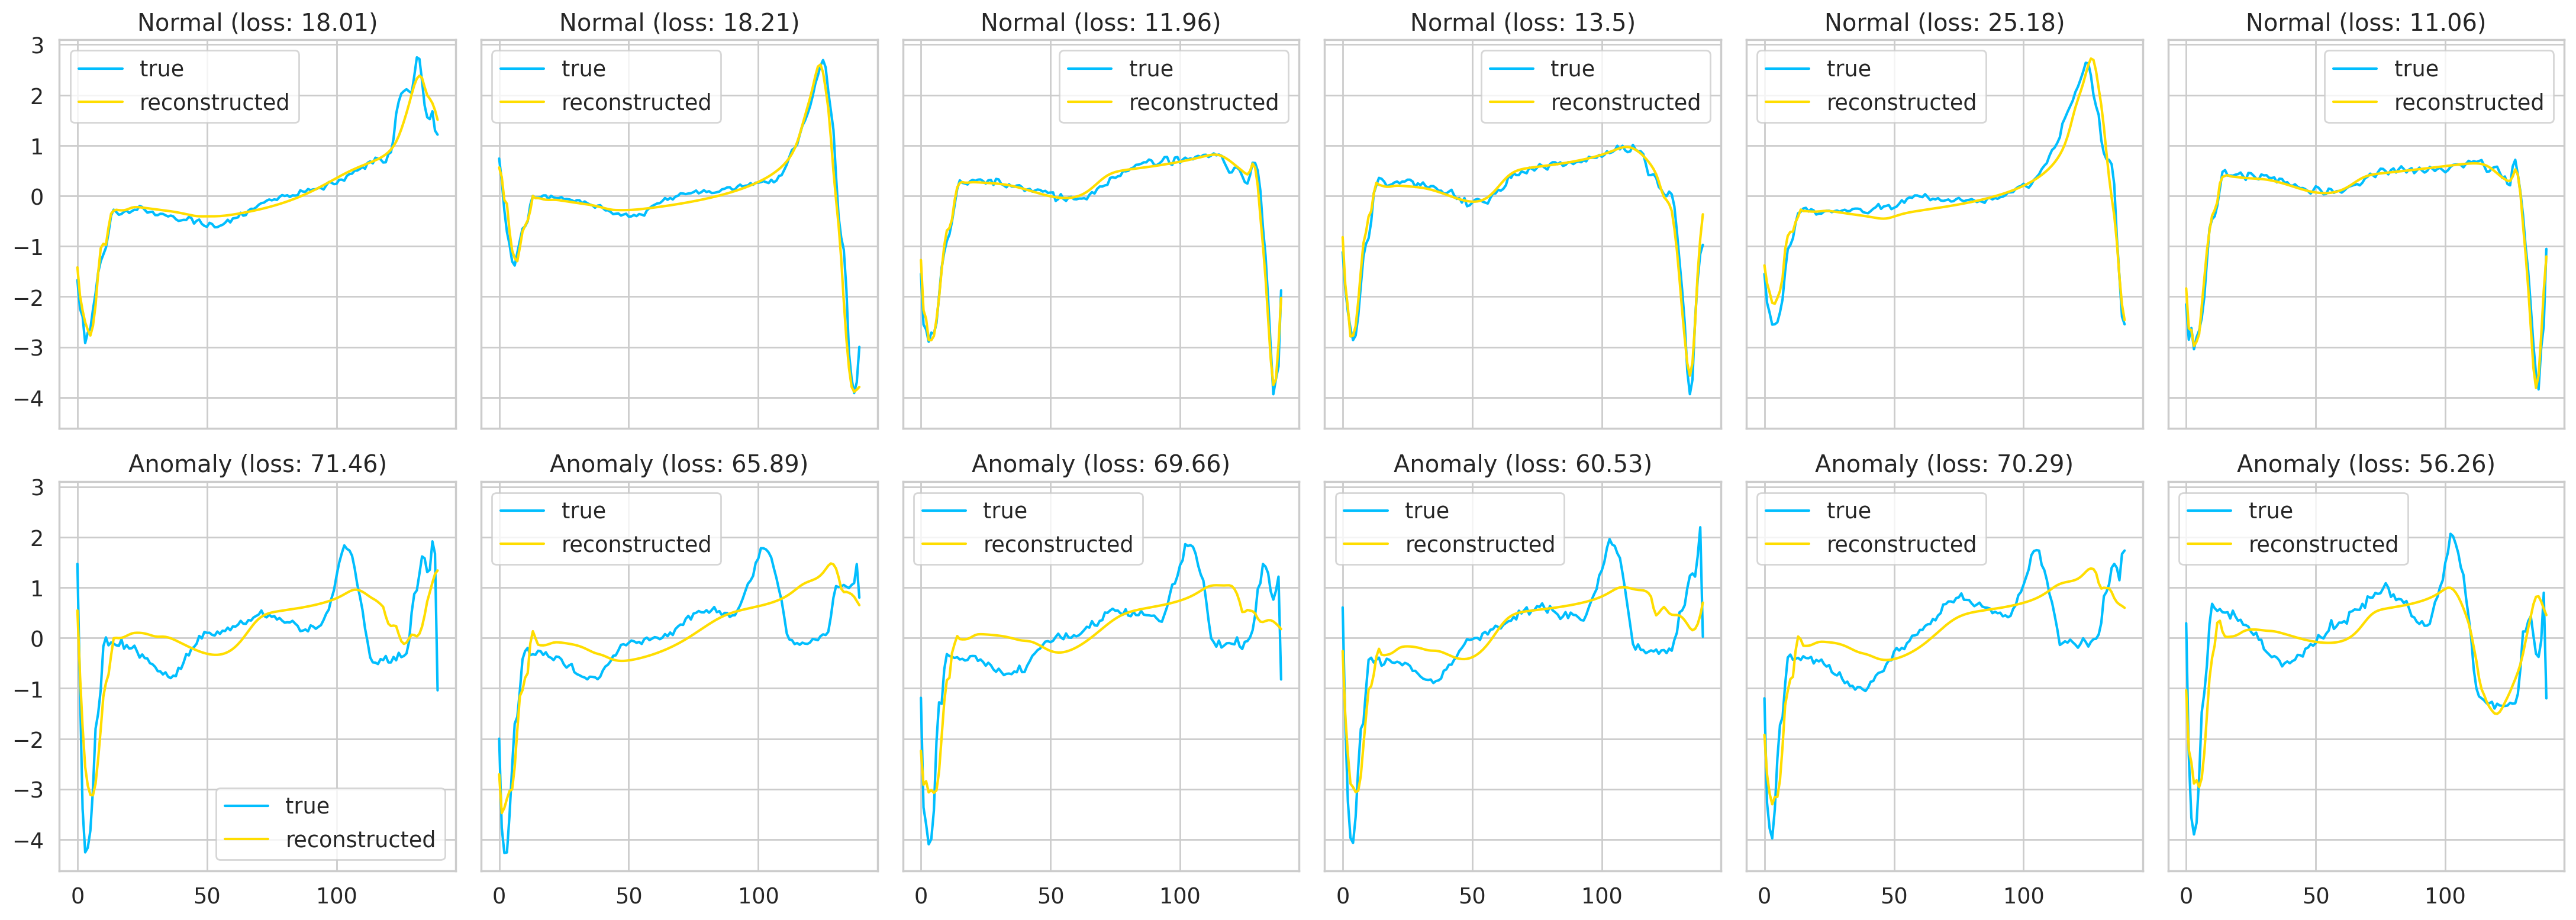

In [56]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model_RNT, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model_RNT, title='Anomaly', ax=axs[1, i])

fig.tight_layout();

In [57]:
PVC_df = df[df.target == b'3'].drop(labels='target', axis=1)
PVC_df.shape

(96, 140)

In [58]:
anomaly_df = df[df.target != b'3'].drop(labels='target', axis=1)
anomaly_df.shape

(4904, 140)

In [59]:
train_df, val_df = train_test_split(
  PVC_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33,
  random_state=RANDOM_SEED
)

In [60]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

In [61]:
model_PVC = RecurrentAutoencoder(seq_len, n_features, 128)
model_PVC = model_PVC.to(device)

In [62]:
model_PVC, history = train_model(
  model_PVC,
  train_dataset,
  val_dataset,
  n_epochs=150
)

Epoch 1: train loss 82.78470781114366 val loss 90.76919097900391
Epoch 2: train loss 82.84841085363317 val loss 89.87770309448243
Epoch 3: train loss 82.56063395370671 val loss 89.95126876831054
Epoch 4: train loss 82.9624776016047 val loss 90.20808029174805
Epoch 5: train loss 82.75627918007933 val loss 90.3340576171875
Epoch 6: train loss 82.70393997945904 val loss 90.32872924804687
Epoch 7: train loss 82.6455941847813 val loss 90.20726928710937
Epoch 8: train loss 82.60900629302601 val loss 89.96762390136719
Epoch 9: train loss 82.62728839450412 val loss 89.94686737060547
Epoch 10: train loss 82.613565798159 val loss 89.89905395507813
Epoch 11: train loss 82.55196258168162 val loss 89.7970359802246
Epoch 12: train loss 82.32050535413954 val loss 89.81545028686523
Epoch 13: train loss 82.5923164744436 val loss 89.44073104858398
Epoch 14: train loss 82.37526302573121 val loss 90.50709915161133
Epoch 15: train loss 82.98310894436307 val loss 90.35470199584961
Epoch 16: train loss 82.80

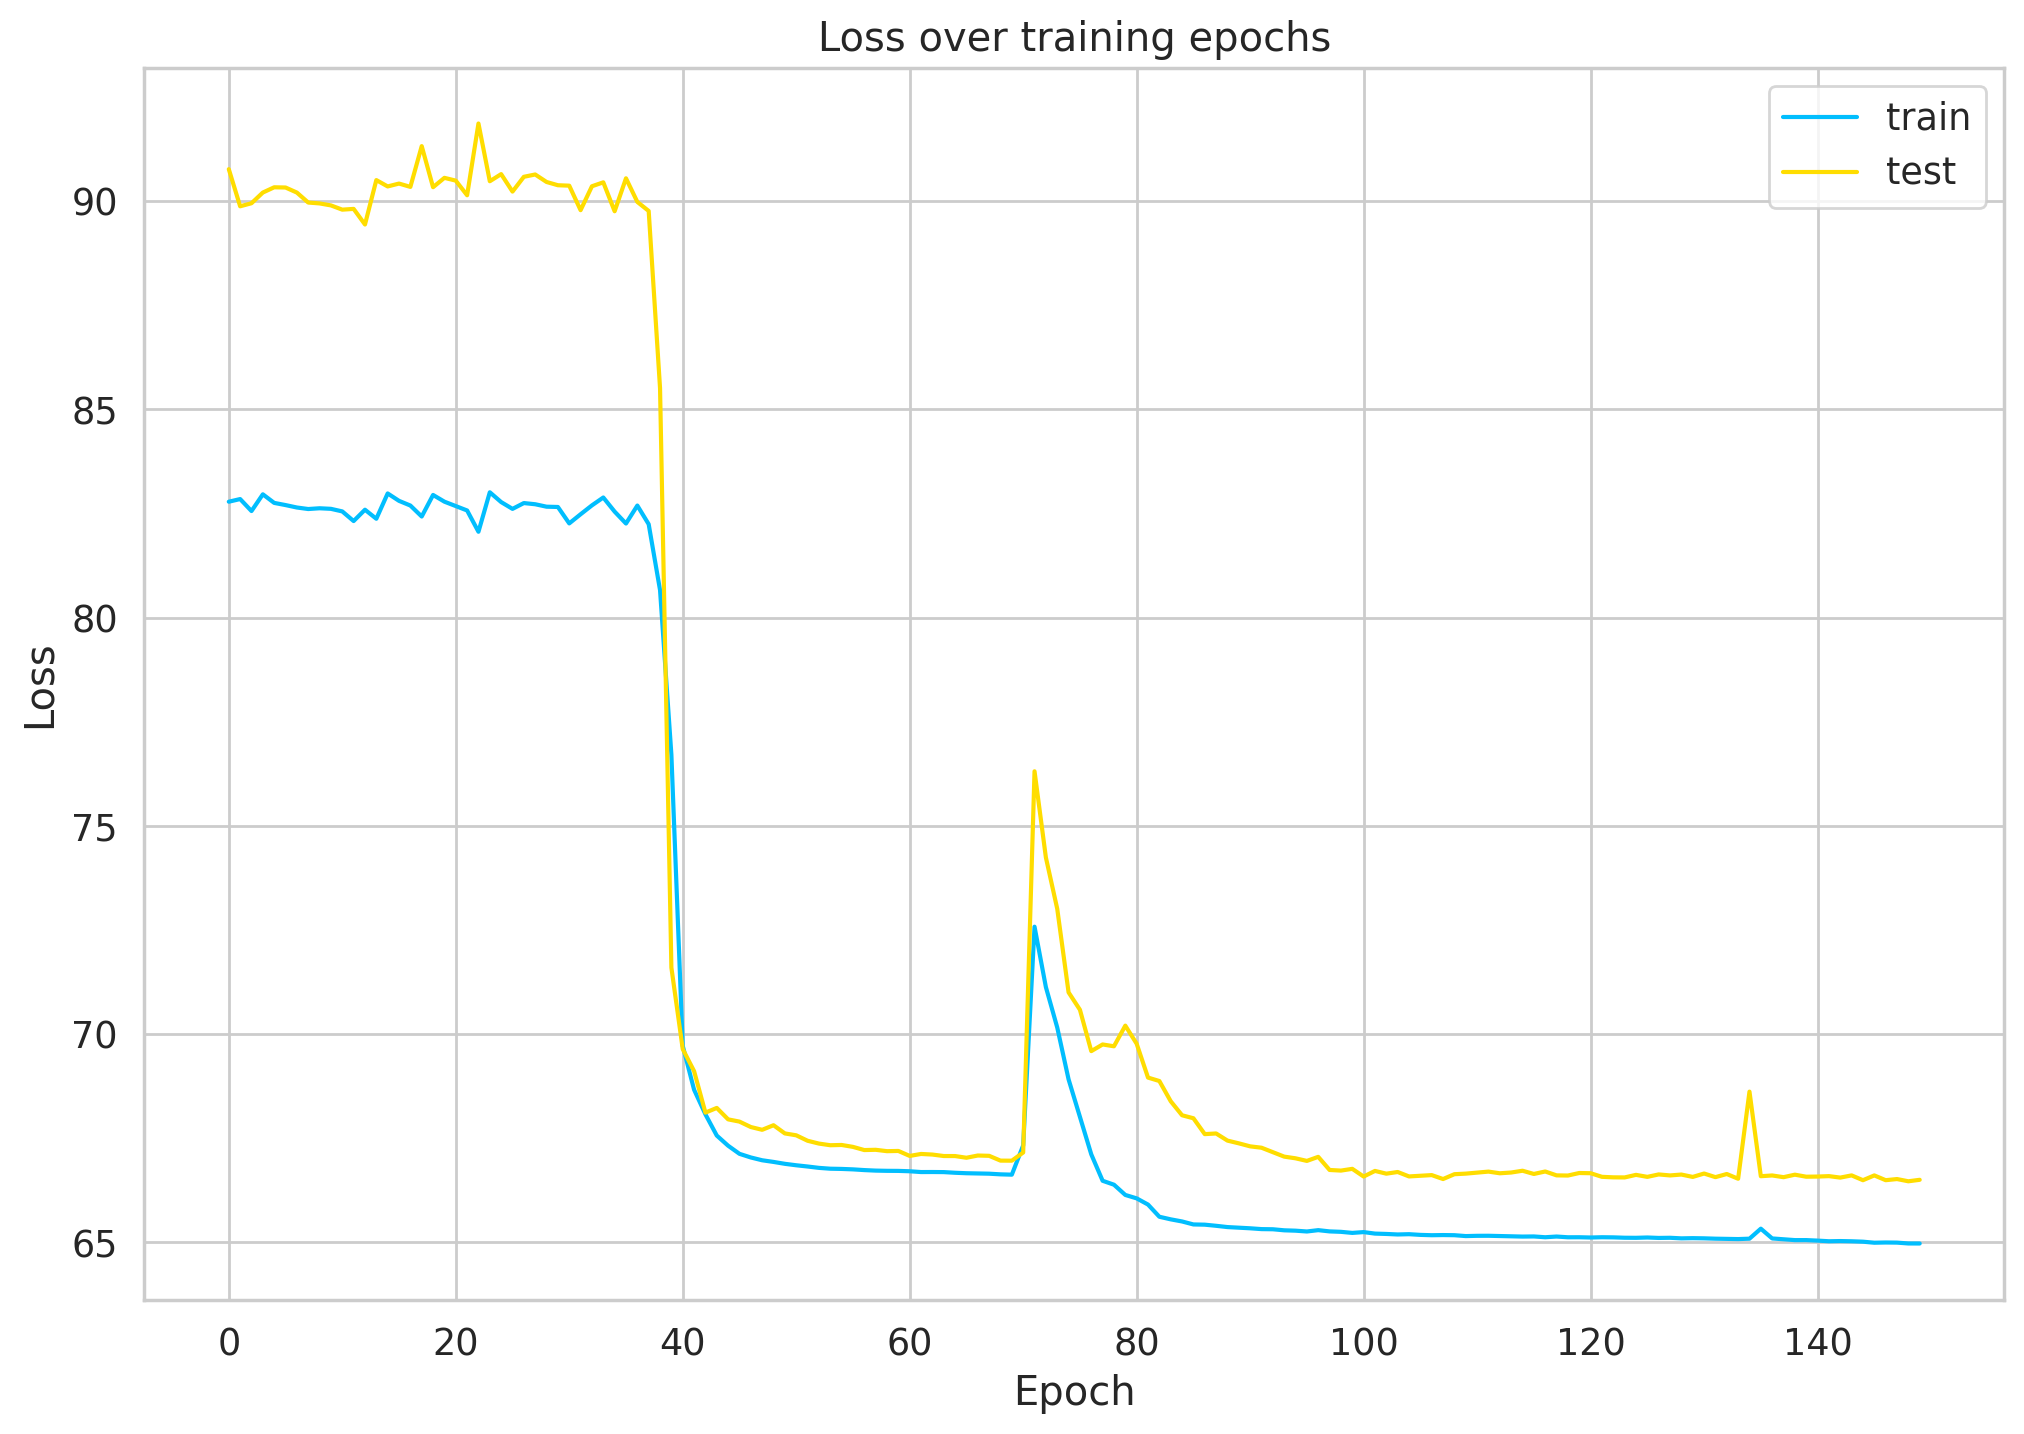

In [63]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [64]:
MODEL_PVC_PATH = 'model_PVC.pth'

torch.save(model_PVC, MODEL_PVC_PATH)

In [66]:
# !gdown --id 1UYy2skQ0Z2ITZQrui6waFSxR3eFsf0jL
# model_PVC = torch.load('model_PVC.pth')
# model_PVC = model_PVC.to(device)

<ipython-input-67-5bf06c7df0c0>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(losses, bins=50, kde=True);


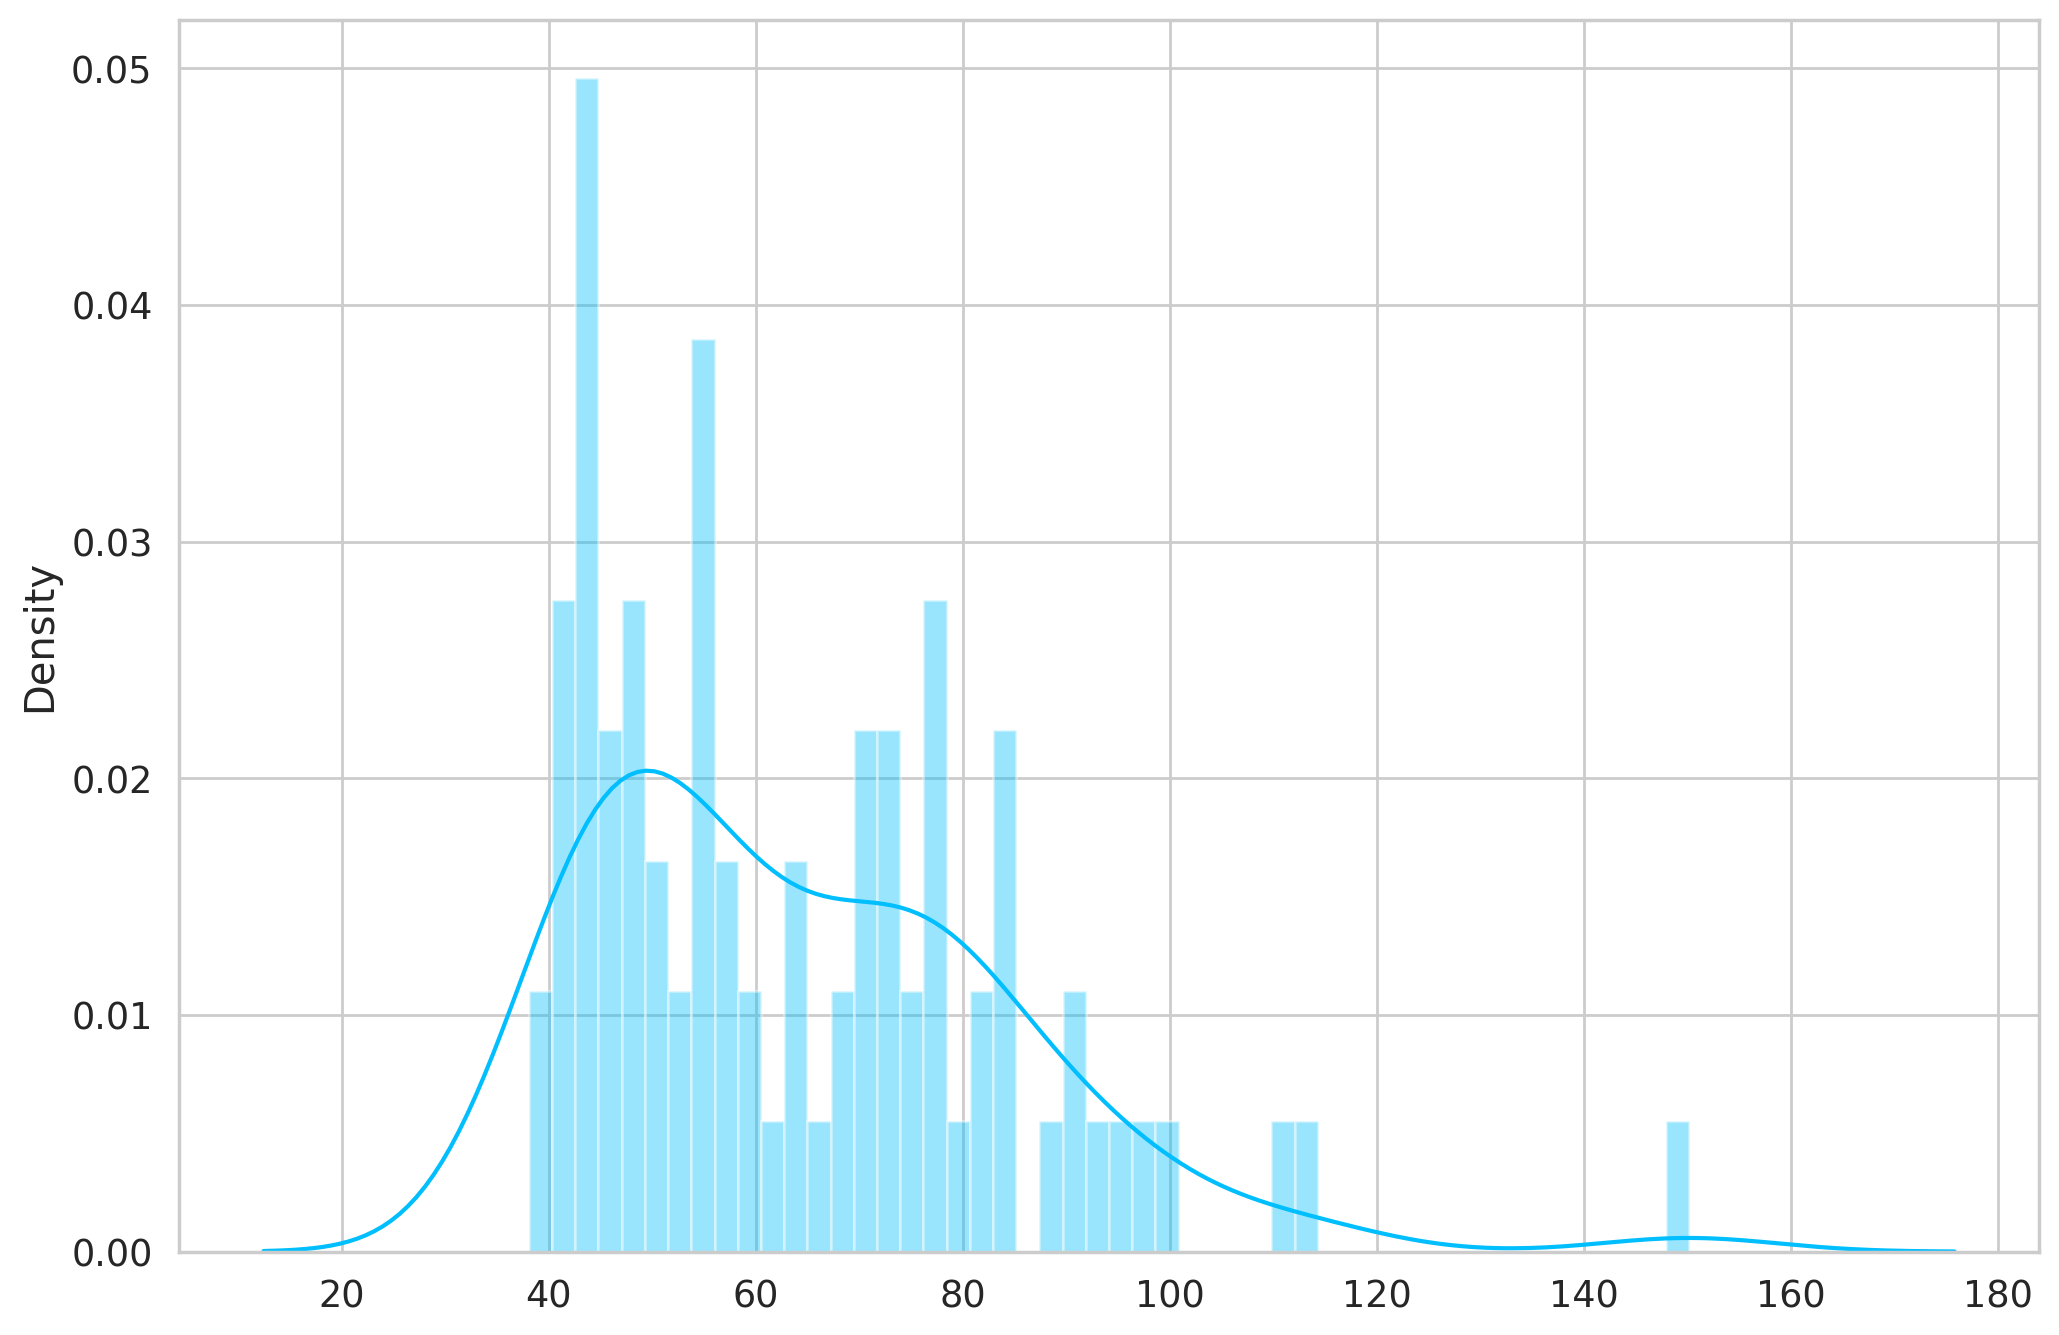

In [67]:
_, losses = predict(model_PVC, train_dataset)
sns.distplot(losses, bins=50, kde=True);

In [68]:
THRESHOLD = 66

<ipython-input-70-c1ae8a4fdd3f>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True);


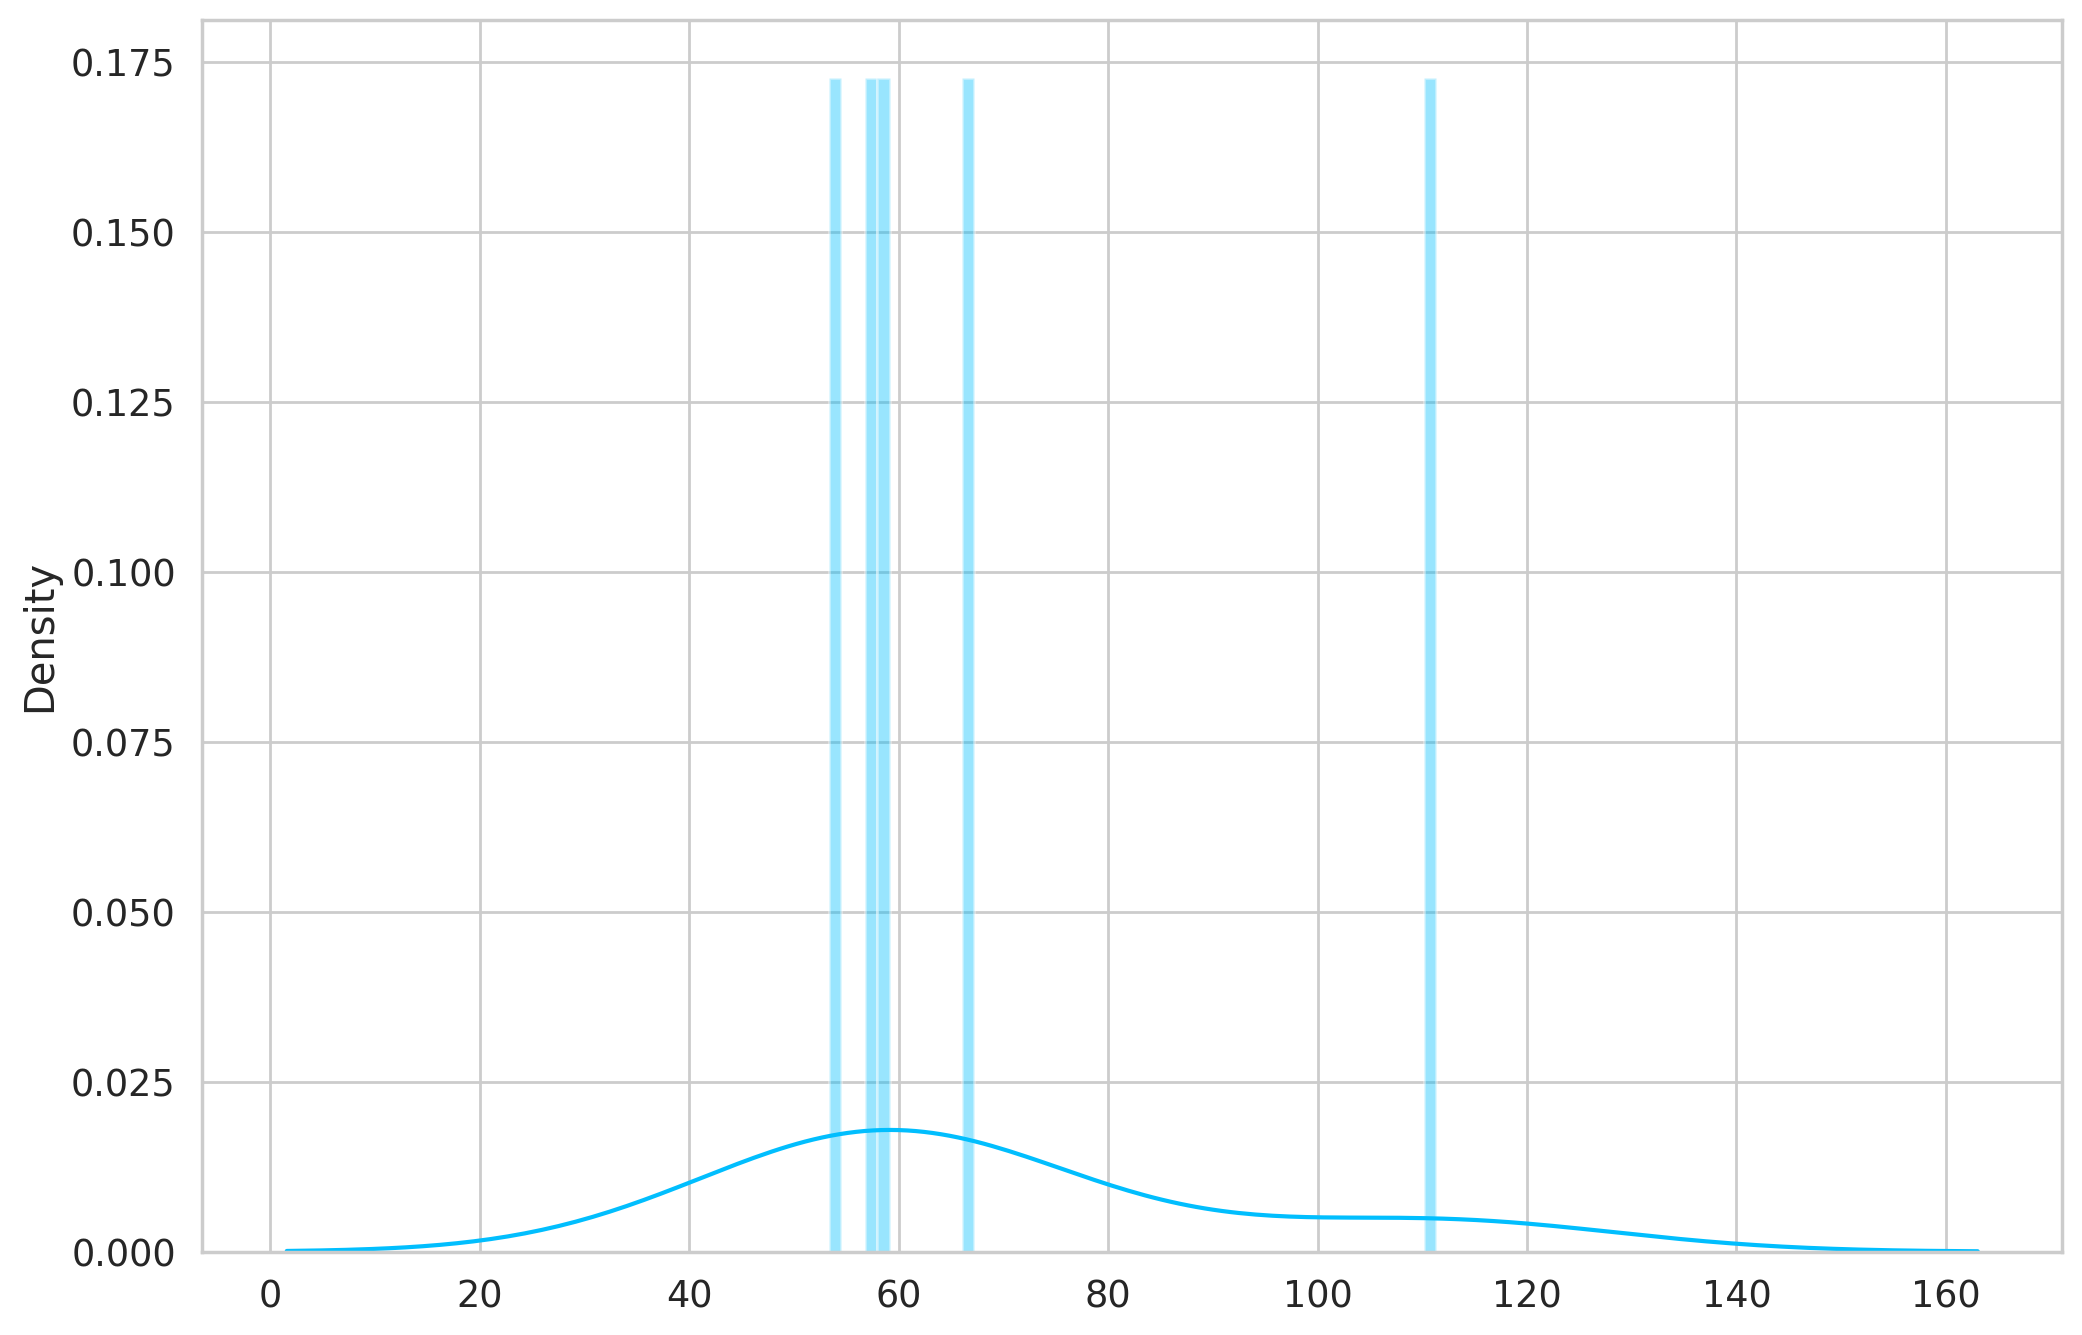

In [70]:
predictions, pred_losses = predict(model_PVC, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [71]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 3/5


In [72]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

<ipython-input-74-666a072e007f>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True);


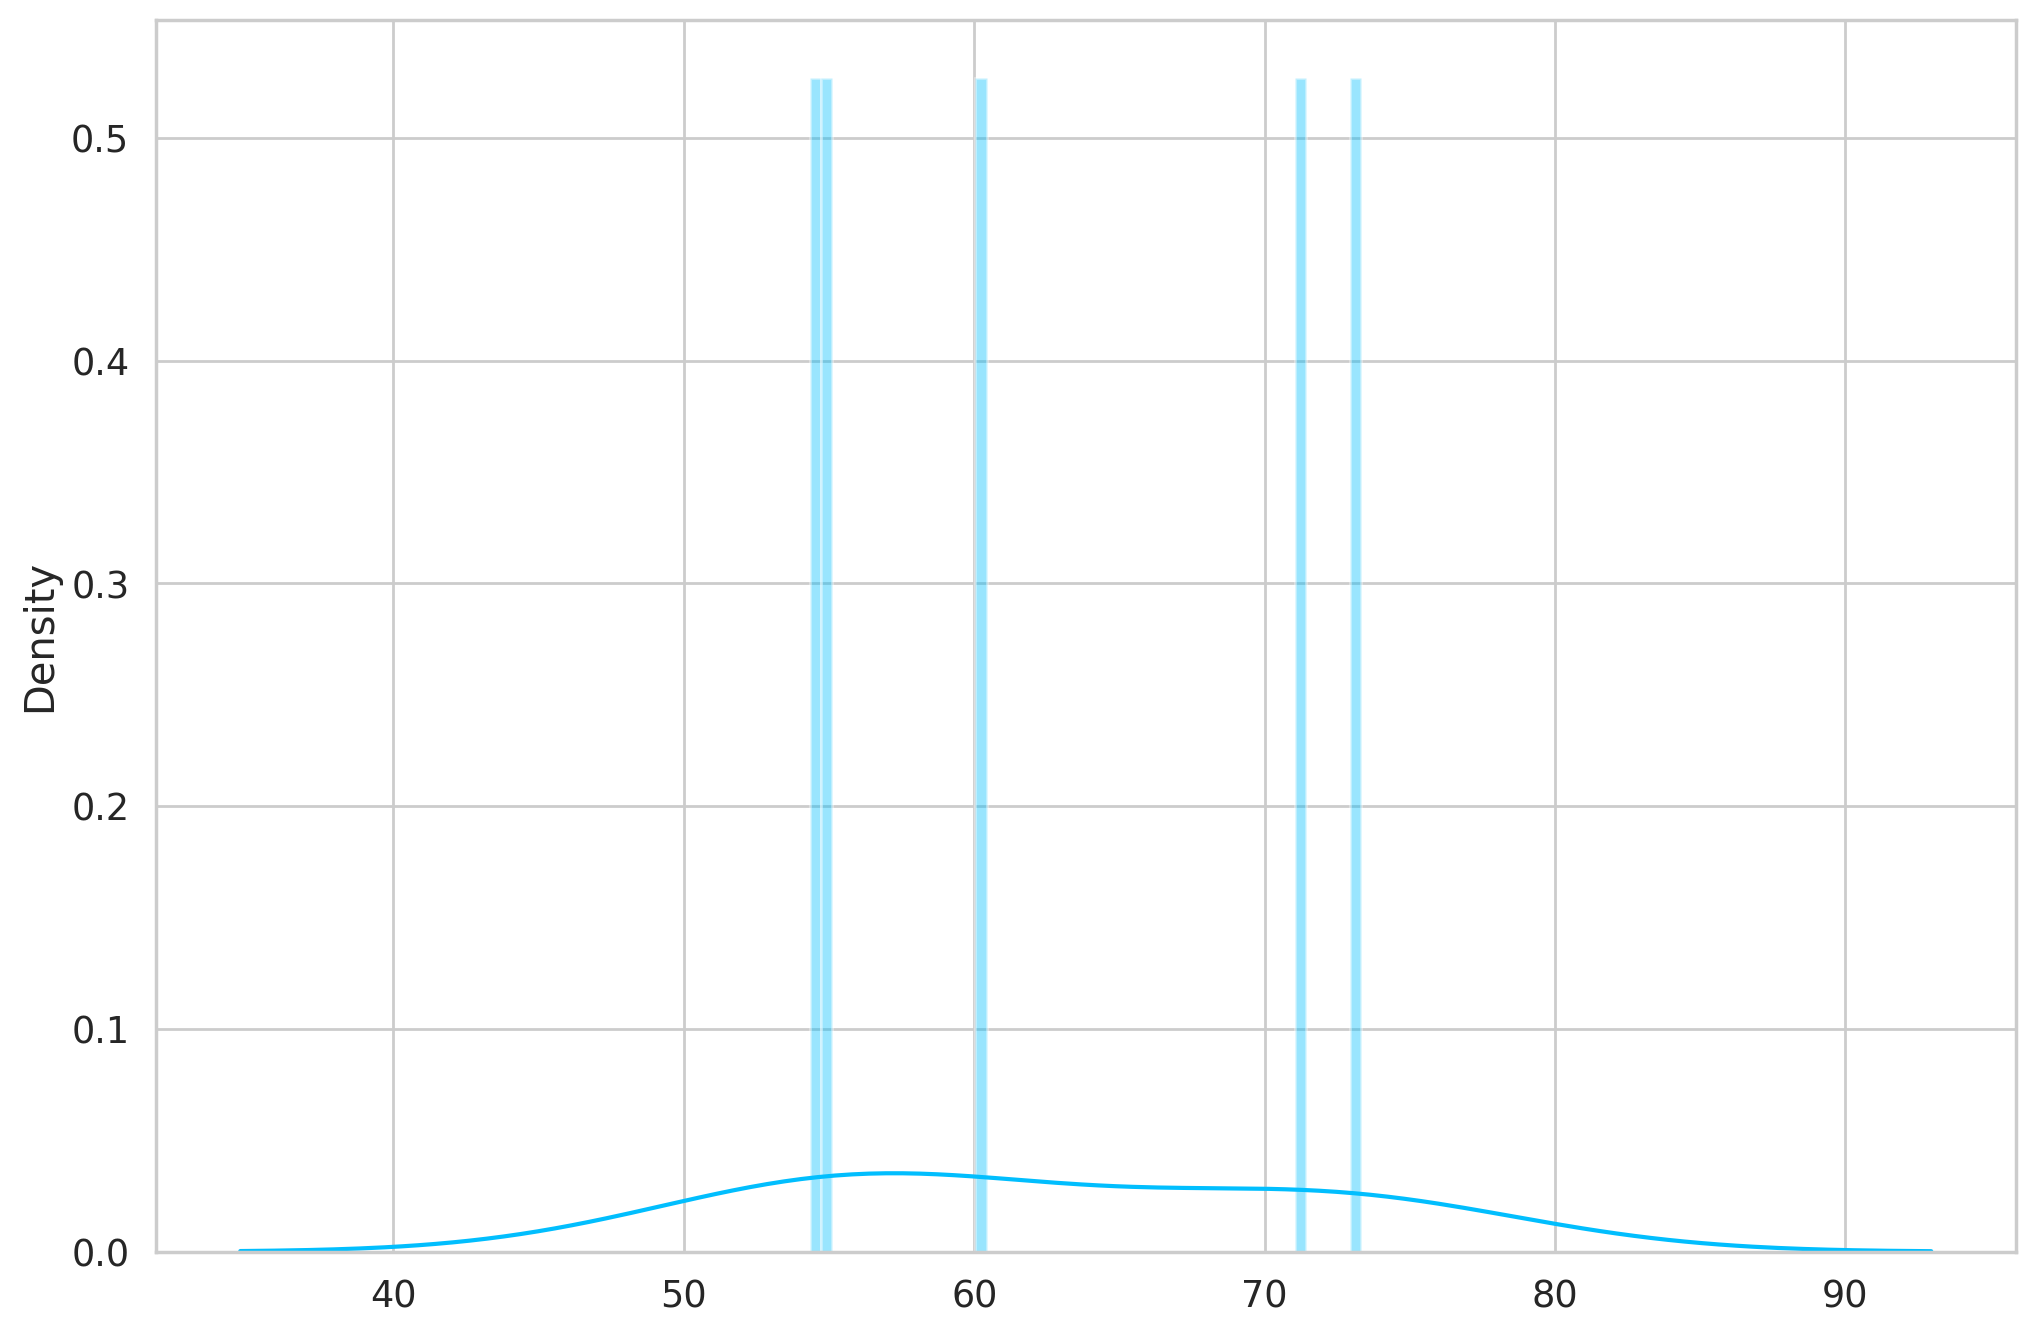

In [74]:
predictions, pred_losses = predict(model_PVC, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [75]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct anomaly predictions: 2/5


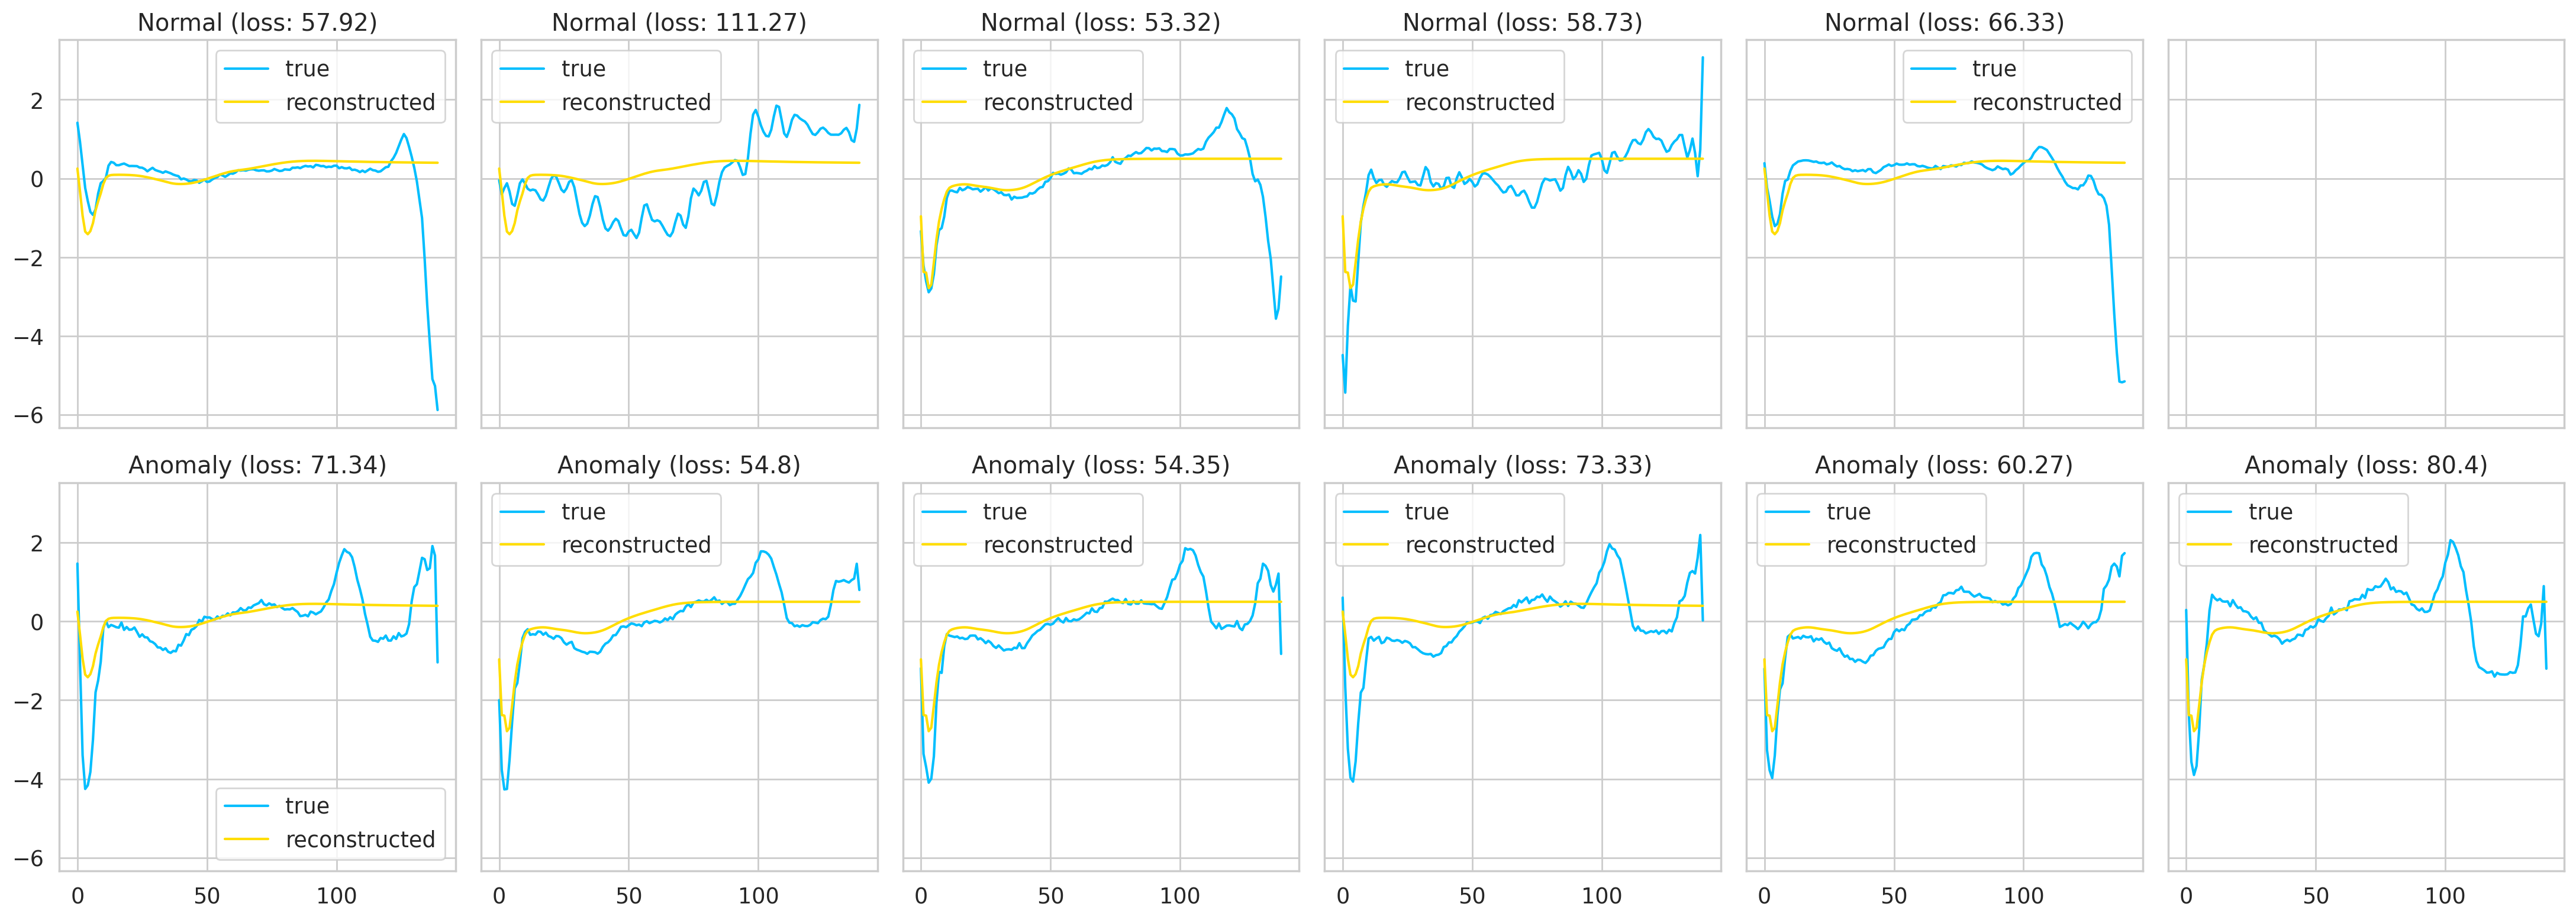

In [76]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model_PVC, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model_PVC, title='Anomaly', ax=axs[1, i])

fig.tight_layout();

In [77]:
SP_df = df[df.target == b'4'].drop(labels='target', axis=1)
SP_df.shape

(194, 140)

In [78]:
anomaly_df = df[df.target != b'4'].drop(labels='target', axis=1)
anomaly_df.shape

(4806, 140)

In [79]:
train_df, val_df = train_test_split(
  SP_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33,
  random_state=RANDOM_SEED
)

In [80]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

In [81]:
model_SP = RecurrentAutoencoder(seq_len, n_features, 128)
model_SP = model_SP.to(device)

In [82]:
model_SP, history = train_model(
  model_SP,
  train_dataset,
  val_dataset,
  n_epochs=150
)

Epoch 1: train loss 89.95771261540855 val loss 89.42455253601074
Epoch 2: train loss 88.66302373932629 val loss 84.15423431396485
Epoch 3: train loss 89.5457494549635 val loss 88.62957305908203
Epoch 4: train loss 91.90126298113567 val loss 90.19279747009277
Epoch 5: train loss 91.85228952547399 val loss 87.49057731628417
Epoch 6: train loss 89.92171799264302 val loss 82.32271614074708
Epoch 7: train loss 70.64279816790325 val loss 66.70739116668702
Epoch 8: train loss 67.01668108963385 val loss 62.7168046951294
Epoch 9: train loss 66.00012258204018 val loss 62.074425506591794
Epoch 10: train loss 65.60823356814501 val loss 61.5286771774292
Epoch 11: train loss 65.39768719091649 val loss 61.22678813934326
Epoch 12: train loss 65.26317275442729 val loss 61.13683433532715
Epoch 13: train loss 63.54992126837009 val loss 57.808824920654295
Epoch 14: train loss 69.97481299609673 val loss 71.12658462524413
Epoch 15: train loss 68.16130370628542 val loss 63.40179634094238
Epoch 16: train loss

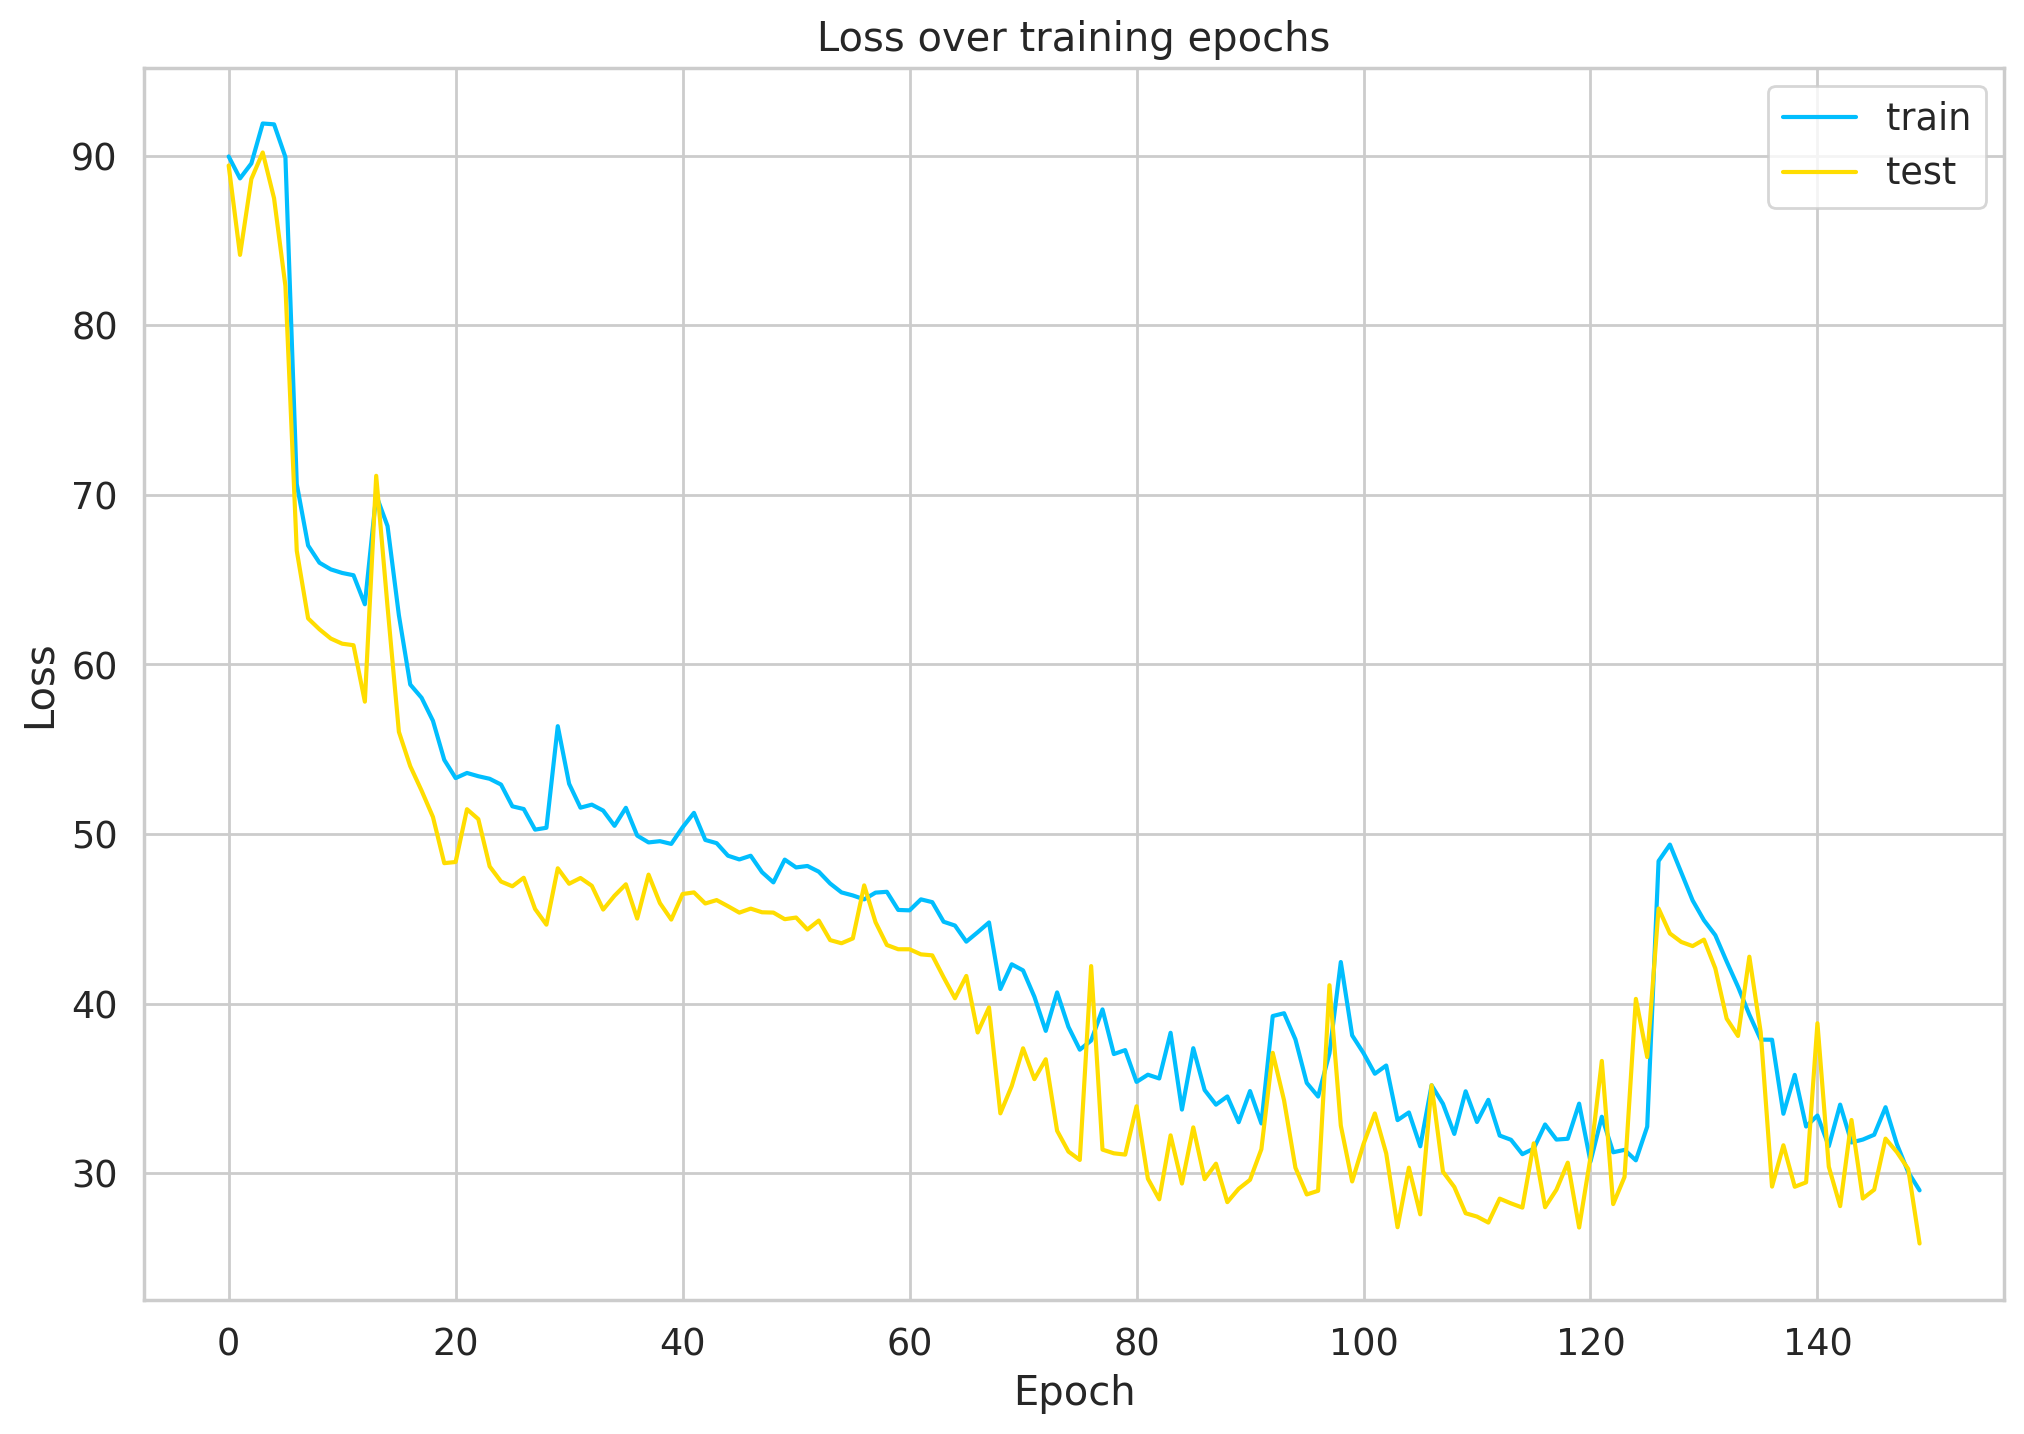

In [83]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [84]:
MODEL_SP_PATH = 'model_SP.pth'

torch.save(model_SP, MODEL_SP_PATH)

In [85]:
# !gdown --id 1xIsKx_R1SzN4kniKzu2HrgT3FJrxwTJh
# model_SP = torch.load('model_SP.pth')
# model_SP = model_SP.to(device)

<ipython-input-86-c7dfcdcefcdb>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(losses, bins=50, kde=True);


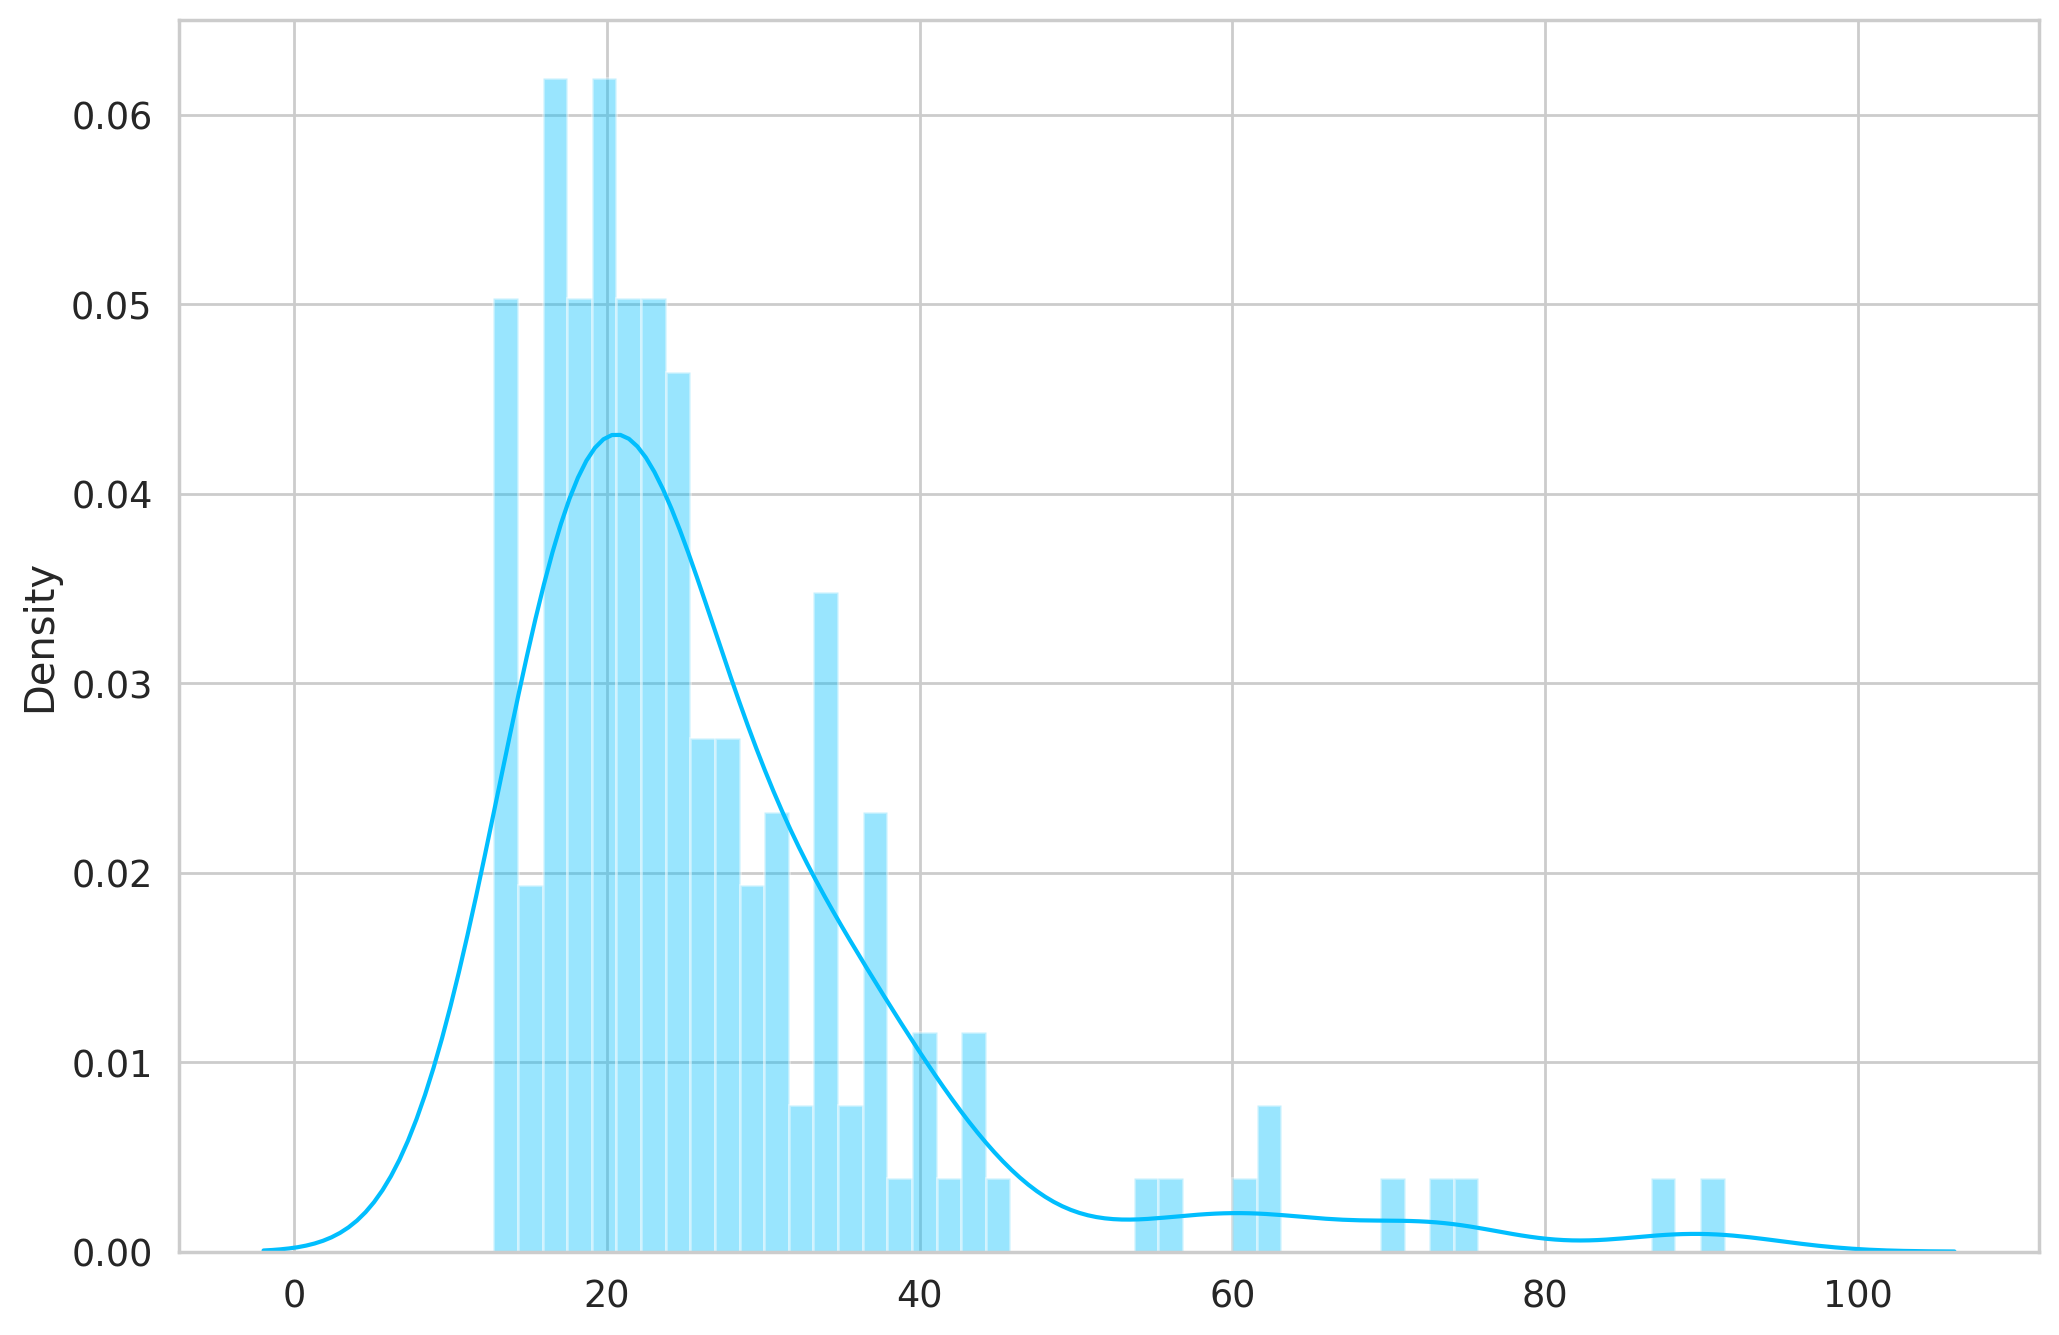

In [86]:
_, losses = predict(model_SP, train_dataset)
sns.distplot(losses, bins=50, kde=True);

In [94]:
THRESHOLD = 36

<ipython-input-95-c7d7e3a08e8c>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True);


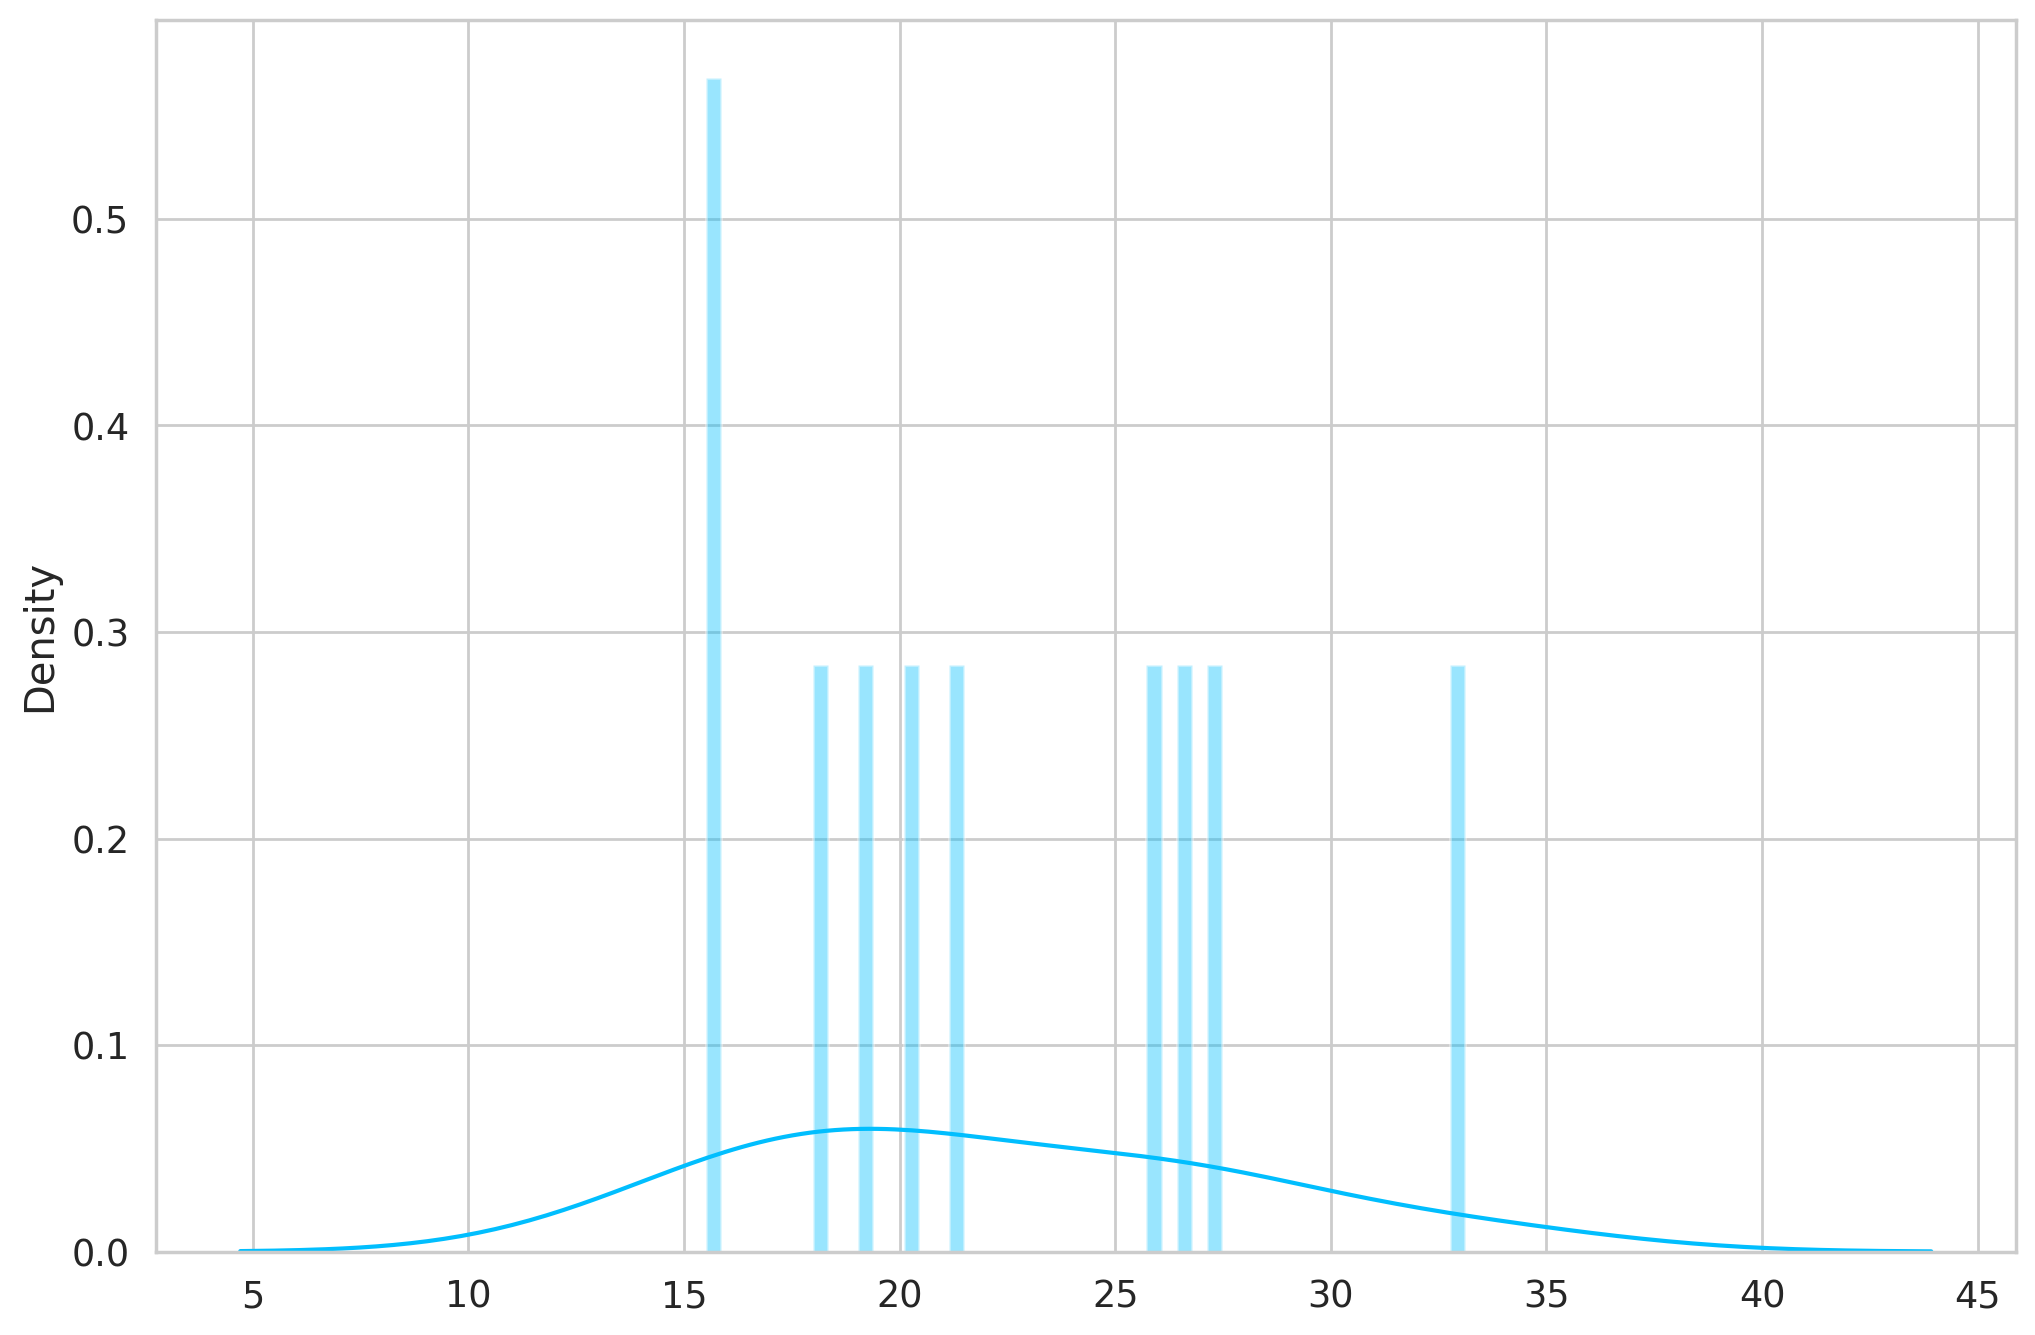

In [95]:
predictions, pred_losses = predict(model_SP, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [96]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 10/10


In [97]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

<ipython-input-98-32c86da28eec>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True);


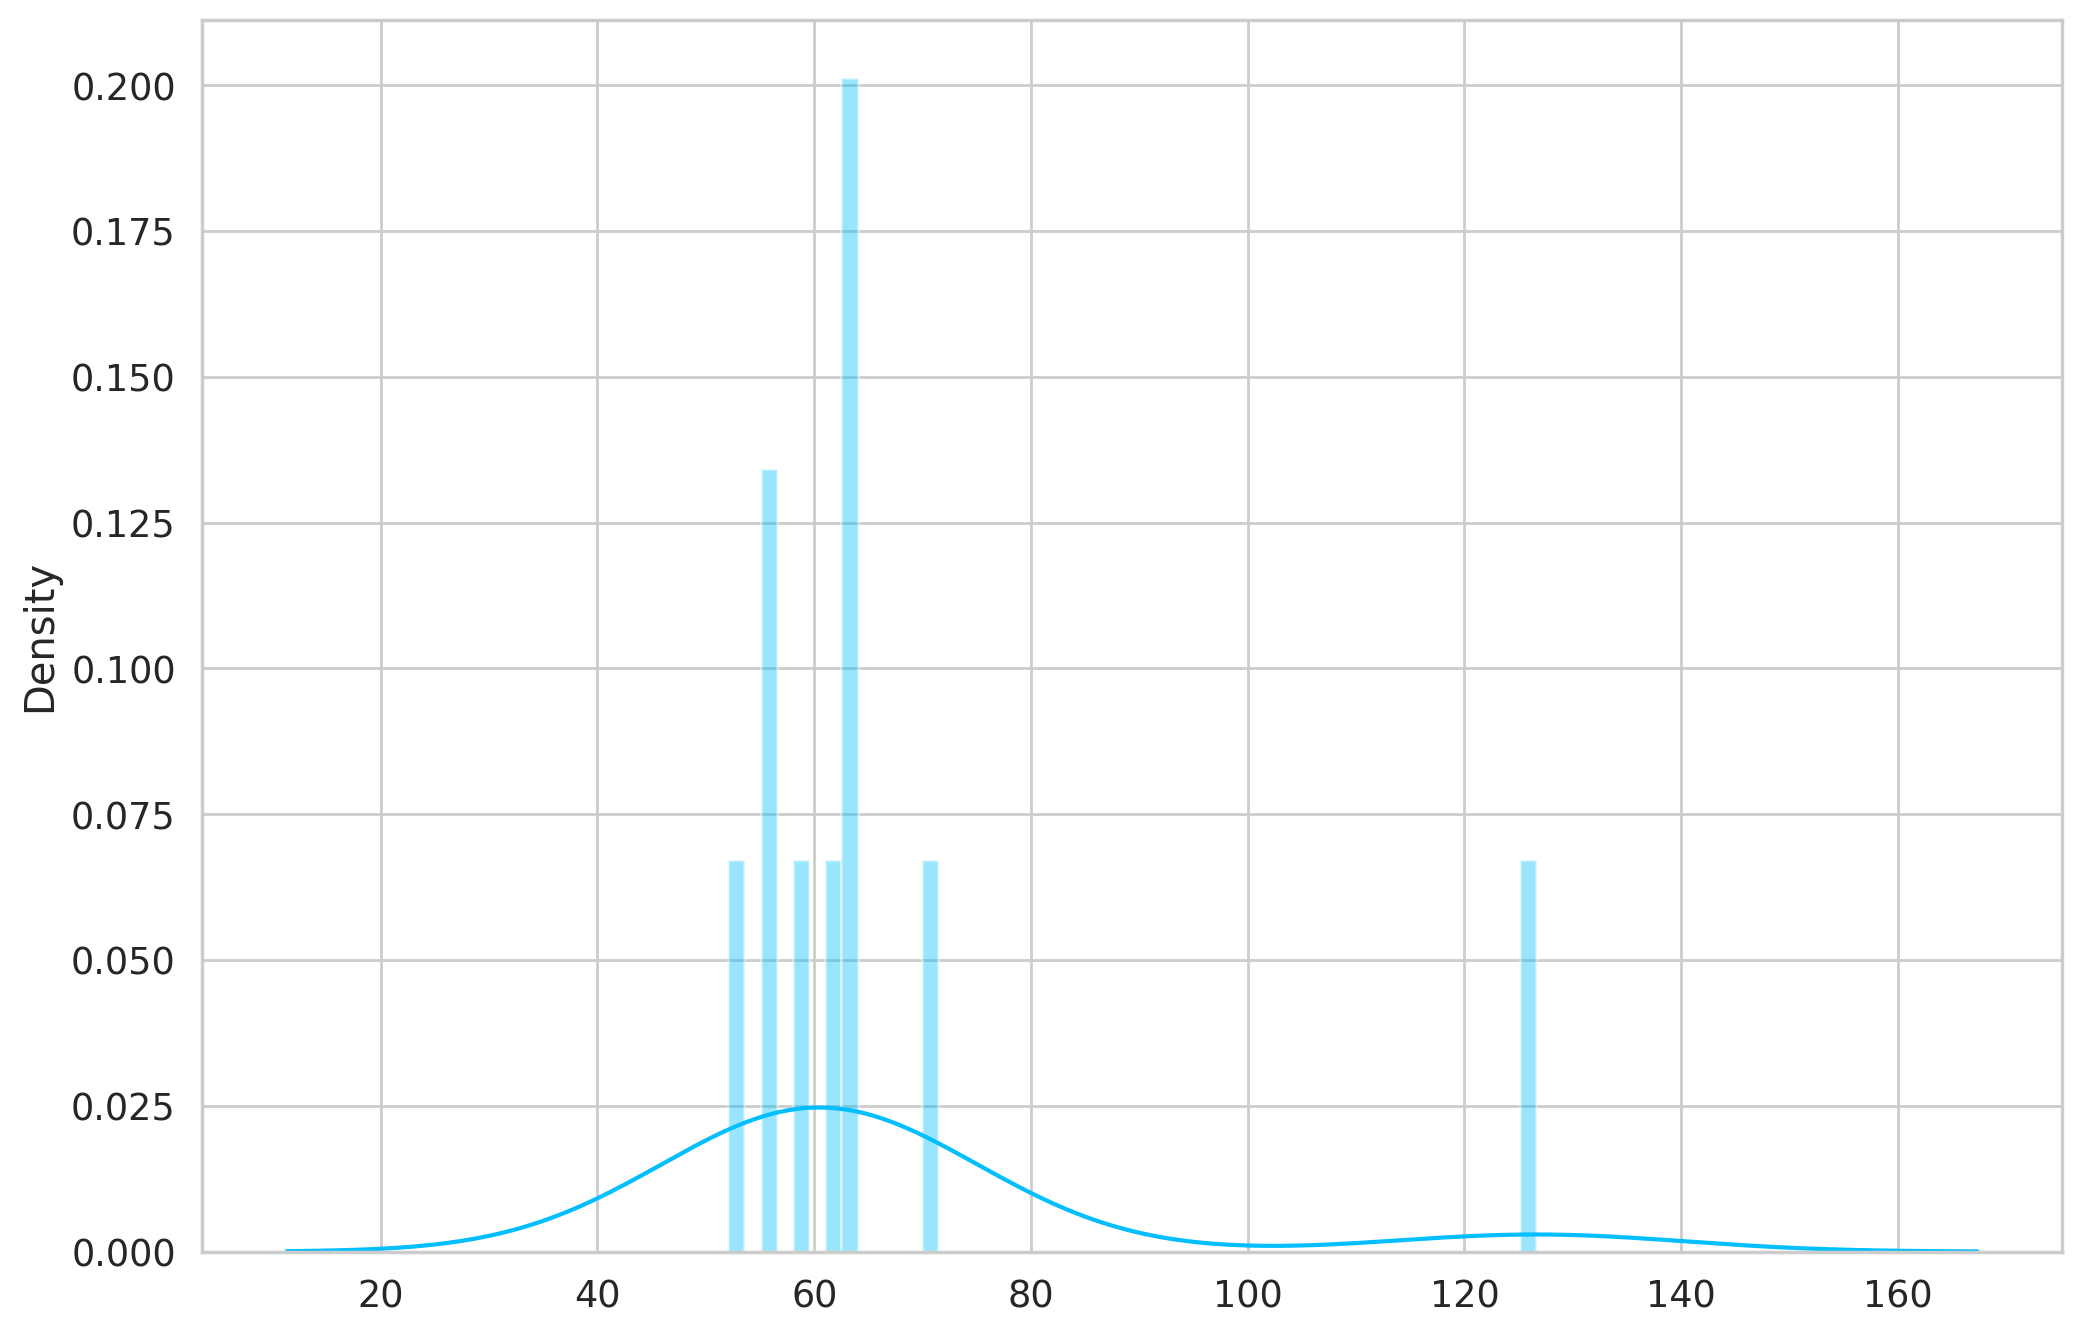

In [98]:
predictions, pred_losses = predict(model_SP, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [99]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct anomaly predictions: 10/10


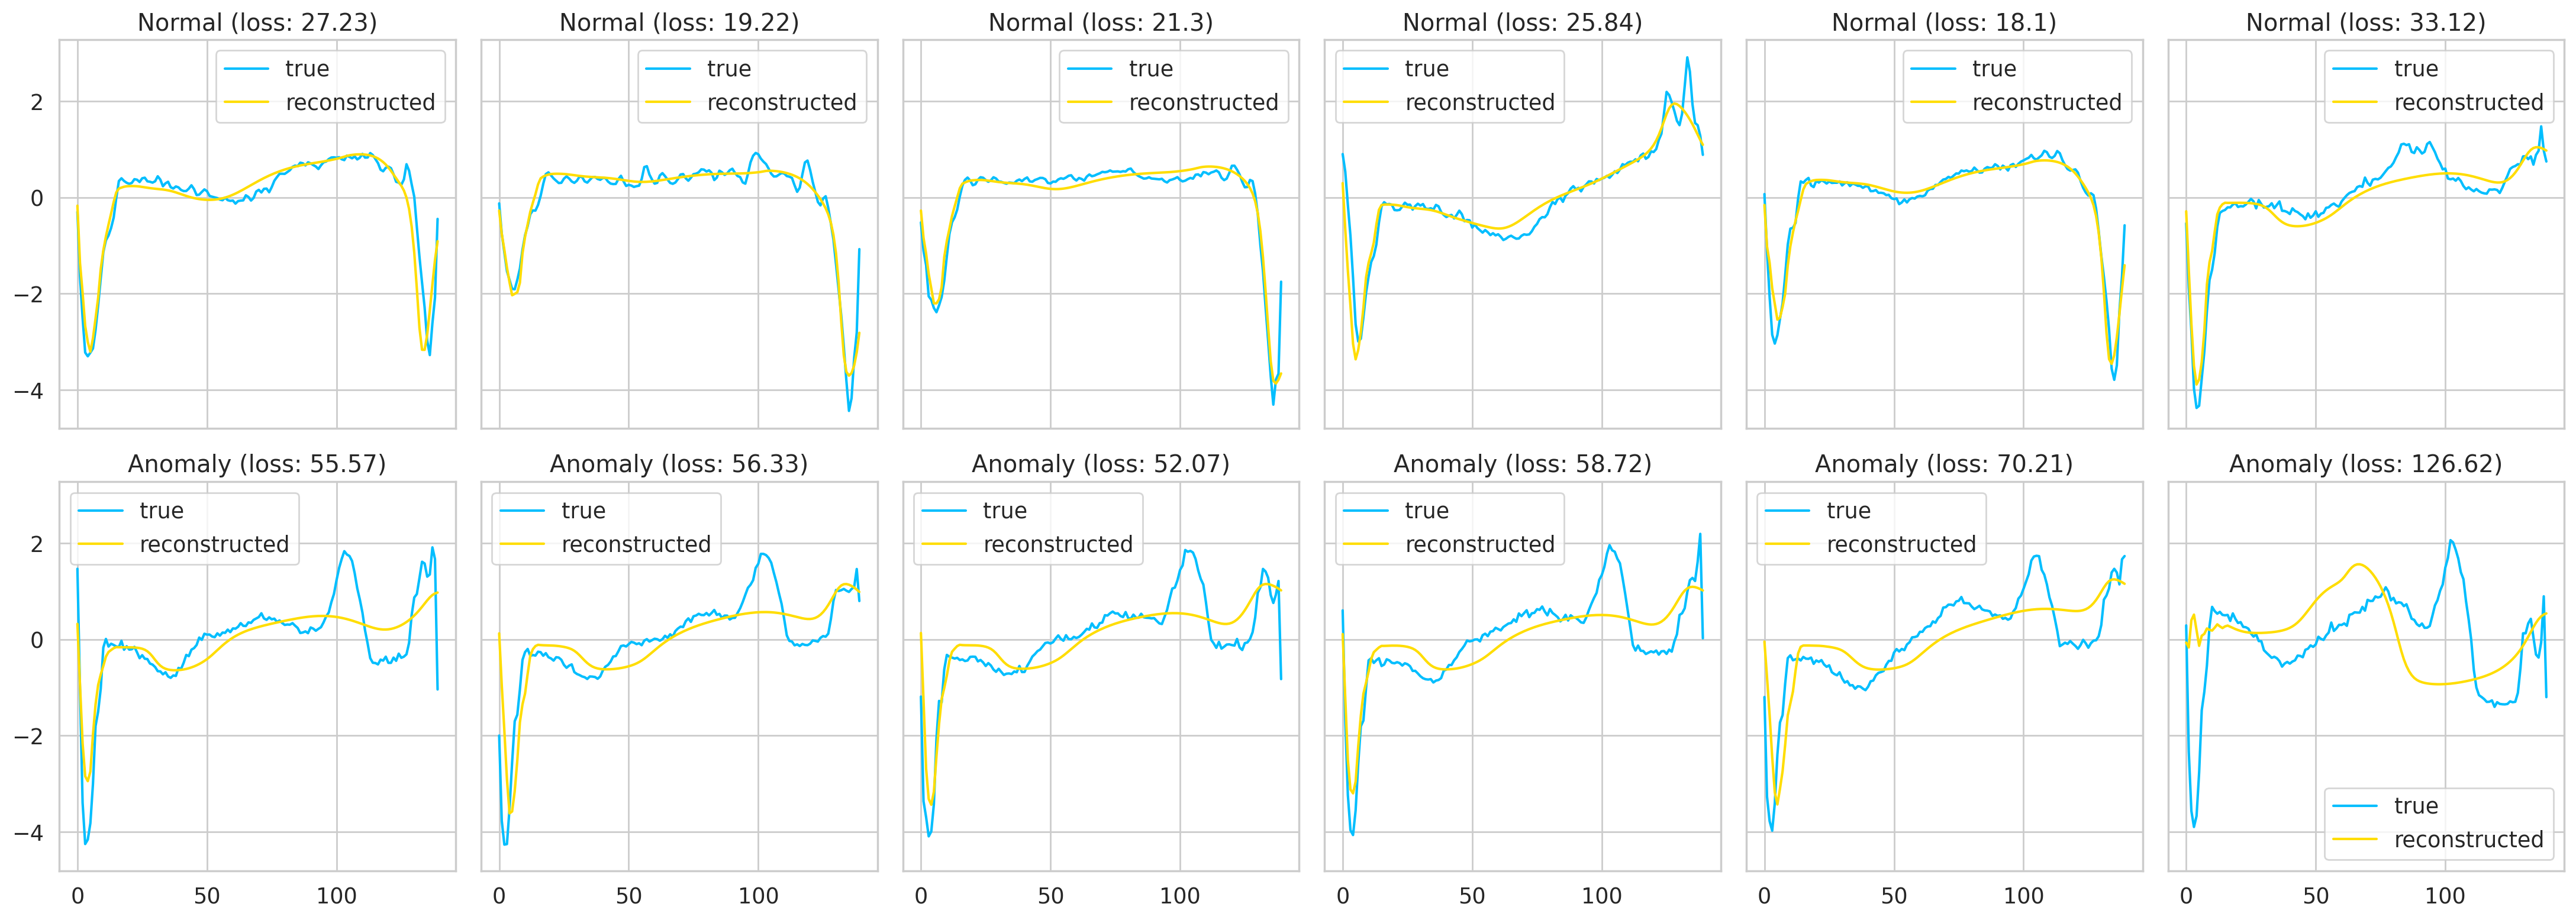

In [100]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model_SP, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model_SP, title='Anomaly', ax=axs[1, i])

fig.tight_layout();